<div style="border:solid Green 2px; border-radius: 10px;  padding: 40px">
<b>Привет, Евгений!👋</b>
    
Меня зовут Зуева Юлия, можно просто Юля 😏 Я буду ревьюером твоего проекта. Предлагаю обращаться на "ты", но если это неудобно, пожалуйста, скажи об этом! 
    
Моя основная цель - помочь тебе стать компетентным Data Scientist'ом: вместе преодолеть трудности и еще больше развить твои сильные навыки 💪 В твоей работе я оставила комментарии, которые должны в этом помочь. Для твоего удобства комментарии раскрашены разными цветами: 
<br/>
<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> В случае корректного решения (или отдельных его моментов). На такие решения можно опираться в будущем.
</div>
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> Если есть возможность как-либо улучшить решение. Ты можешь учесть эти комментарии при доработке проекта, однако для зачета это не обязательно.
</div>
<div style="border-radius: 10px" class="alert alert-block alert-danger">
<b>Нужно доработать ❌:</b> Если решение требует внесения правок. Проект не может быть принят, если остались не отработанные комментарии данного типа.
</div>
    
Чтобы наша с тобой работа была еще эффективнее, ты точно так же можешь оставлять комментарии и задавать мне вопросы. Для таких случаев, пожалуйста, выбери собственное оформление комментариев, которое будет отличаться от моего, чтобы не создавалась путаница. По этой же причине попрошу тебя не удалять и не изменять мои комментарии. Все это позволит лучше ориентироваться в нашем с тобой диалоге, а повторную проверку (в случае ее необходимости) выполнять оперативнее 🚀
    
Не спеши расстраиваться, если что-то не удалось с первого раза. Вместе мы обязательно разберемся со всеми трудностями! 🤓

# Анализ лояльности пользователей Яндекс Афиши

<div style="border:solid #D3D3D3 2px; border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Вводная часть <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> В любой работе важно оставлять вводную часть. Она помогает быстро понять цель, контекст и структуру работы, что будет удобно не только для тебя при возвращении к проекту спустя время, но и любому другому читателю (если, например, публикуешь в открытый доступ для портфолио). Воспринимаем эту тетрадку не просто как выполнение домашней работы на курсе, а как полноценный исследовательский проект.

Како правило, во вводную часть включают название проекта, краткое описание цели, используемых данных (источники, объем, особенности), нюансы самого проекта (специфические условия, ограничения, предположения и т.д.). Иногда также сразу обозначают план шагов. Другими словами, вводная часть призвана отразить, что мы делаем, с чем работаем и на каких условиях.
</div>
    
    
<h4> Оформление проекта <a class="tocSkip"></h4>
    

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 
    
* Задания стоит переформулировать в собственные исследовательские вопросы.
    
    
* Согласно стандартам оформления кода не стоит делать строки длиной более 79 символов, это портит его читаемость, вынуждает прокручивать ячейку.
    
    
* `print` используется для простого текстового вывода. Но в средах с поддержкой rich output (Jupyter, IPython) также доступен `display`. Для объектов, где важно сохранить форматирование или визуализацию (DataFrame, картинки, графики, HTML и т.д.) лучше использовать его.  
    
    
* Это исследовательская работа, а не скрипт, поэтому важно фиксировать свой ход мыслей, пояснять свои шаги и делать выводы относительно результатов, то есть вести последовательный сторителлинг, что зачем и почему мы делаем, что по итогу получаем, достигли ли нужного нам результата.
    
    
* Выводы не принято писать через `print`, это явный признак ИИ, из-за чего доверия к работе существенно меньше.
    
</div>

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:


Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# Установка всех библиотек через правильный путь к Python
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scipy sqlalchemy psycopg2-binary python-dotenv phik

print("✅ Все библиотеки установлены!")

# Теперь импортируем
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sqlalchemy import create_engine
import phik
from phik.report import plot_correlation_matrix

print(f"✅ Pandas версия: {pd.__version__}")
print(f"✅ Phik версия: {phik.__version__}")


✅ Все библиотеки установлены!
✅ Pandas версия: 2.2.3
✅ Phik версия: 0.12.5


In [3]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install psycopg2-binary
!{sys.executable} -m pip install sqlalchemy
!{sys.executable} -m pip install python-dotenv

In [4]:
# СНАЧАЛА УСТАНАВЛИВАЕМ
import sys
!{sys.executable} -m pip install pandas

# ПОТОМ ИМПОРТИРУЕМ
import pandas as pd
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

In [5]:
# Загружаем переменные из .env файла
load_dotenv()

# Берем настройки из .env
connection_params = {
    'host': os.getenv('HOST'),
    'port': os.getenv('PORT'),
    'database': os.getenv('NAME'),
    'user': os.getenv('USER'),
    'password': os.getenv('PASSWORD')
}

# Создаем подключение
connection_string = f"postgresql://{connection_params['user']}:{connection_params['password']}@{connection_params['host']}:{connection_params['port']}/{connection_params['database']}"
engine = create_engine(connection_string)


# тест соединения
test_df = pd.read_sql("SELECT 1 as test", engine)

In [6]:
# Все таблицы во всех схемах
all_tables = """
SELECT table_schema, table_name 
FROM information_schema.tables 
WHERE table_type = 'BASE TABLE'
ORDER BY table_schema, table_name;
"""
all_tables_df = pd.read_sql(all_tables, engine)

print(all_tables_df)

   table_schema                  table_name
0        afisha                        city
1        afisha                      events
2        afisha                   purchases
3        afisha                     regions
4        afisha                      venues
..          ...                         ...
67       public              financial_data
68       public                joined_table
69       public  playground_customer_orders
70       public               prolongations
71       public                temp_devices

[72 rows x 2 columns]


In [7]:
#Фильтрация
device_filter = ("mobile", "desktop", "tablet")
event_type_filter = (
    "концерты", "театр", "выставки", "ёлки", "фильм", "спорт", "стендап"
)

Проанализируем распределение устройств и типов мероприятий.
Категория tablet составляет менее 0.5% наблюдений, а фильм — менее 0.1%.
Для повышения устойчивости статистических выводов исключим данные сегменты из анализа.

In [8]:
device_filter = ("mobile", "desktop")

event_type_filter = (
    "концерты",
    "театр",
    "спорт",
    "стендап",
    "выставки",
    "ёлки"
)

sql_query = """
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.event_id,
    p.service_name,
    e.event_type_main,
    r.region_name,
    c.city_name
FROM afisha.purchases p
LEFT JOIN afisha.events e ON p.event_id = e.event_id
LEFT JOIN afisha.city c ON e.city_id = c.city_id
LEFT JOIN afisha.regions r ON c.region_id = r.region_id
WHERE p.device_type_canonical IN %(device_types)s
  AND e.event_type_main IN %(event_types)s
"""
params = {"device_types": device_filter, "event_types": event_type_filter}

df = pd.read_sql(sql_query, engine, params=params)

In [9]:
df.shape
display(df["device_type_canonical"].value_counts())
display(df["event_type_main"].value_counts())

device_type_canonical
mobile     177829
desktop     46915
Name: count, dtype: int64

event_type_main
концерты    115276
театр        67321
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: count, dtype: int64

<div style="border:solid #D3D3D3 2px; border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Импорты <a class="tocSkip"></h4>


<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b>

* Чтобы при установке новой библиотеки не выводилась информация о процессе и зависимостях, можно добавлять опцию `--quiet` или просто `-q`. 
 
    
* Все необходимые библиотеки лучше подгружать сразу в начале проекта, это соответствует стандартам оформления кода <a href='https://pyplanet.ru/article/pep-0008.html'>PEP 8</a>. Такой подход позволяет сразу видеть, какое окружение необходимо для запуска проекта, избежать дублирования импортов в разных частях кода, а также облегчить отладку и переносимость проекта. 
    
    
* Импорты не должны дублироваться. Подгружаем только то, что используется в проекте.
    
    
* Хорошей практикой также является упорядочивание импортов. PEP 8 рекомендует сначала подгружать стандартные python-библиотеки, затем сторонние. Но для удобства каждую их этих групп также можно структурировать по тематике. Например, библиотеки для работы с данными, для работы с графиками и т.д. Так удобнее поддерживать порядок в импортах от проекта к проекту, не подгружать лишнее.

    
</div>
    
    
<h4> Загрузка данных <a class="tocSkip"></h4>
<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> Здорово, что засекречиваешь подключение! Лучше сразу в процессе работы держать чувствительные значения отдельно от основного содержания, иначе есть высокий риск забыть об этом нюансе.

</div>


<div style="border-radius: 10px" class="alert alert-block alert-danger">
 
<b>Нужно доработать ❌:</b> Обрати внимание, что для анализа нам требовались не все данные. Необходимо наложить фильтрацию на тип устройства и мероприятия.
    
</div>

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> Импортирование библиотек и подгрузка данных - это отдельные этапы работы, поэтому их лучше разместить в отдельных разделах.
</div>

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [10]:
#Обьем данных 
df.shape

(224744, 13)

In [11]:
#Типы даных 
df.dtypes

user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
event_id                          int64
service_name                     object
event_type_main                  object
region_name                      object
city_name                        object
dtype: object

In [12]:
df.memory_usage(deep=True).sum() / 1024 / 1024

np.float64(123.45996379852295)

In [13]:
#пропуски 
missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).sort_values(ascending=False)

missing_summary = pd.DataFrame({
    "missing_count": missing,
    "missing_pct": missing_pct
}).query("missing_count > 0")

display(missing_summary)

,missing_count,missing_pct


In [14]:
#Числовые покаозатели 
df[['revenue', 'tickets_count']].describe()

,revenue,tickets_count
count,224744.000000,224744.000000
mean,735.624314,2.749818
std,1357.962786,1.144488
min,-90.760000,1.000000
25%,187.690000,2.000000
50%,472.590000,3.000000
75%,922.390000,3.000000
max,81174.540000,47.000000


In [15]:
# Eybrfkmyst pyfxftybz
summary_uniques = pd.Series({
    "users": df["user_id"].nunique(),
    "orders": df["order_id"].nunique(),
    "events": df["event_id"].nunique(),
    "services": df["service_name"].nunique(),
    "cities": df["city_name"].nunique(),
    "regions": df["region_name"].nunique(),
    "device_types": df["device_type_canonical"].nunique(),
    "event_types": df["event_type_main"].nunique()
})

display(summary_uniques)

users            18714
orders          224744
events           17769
services            33
cities             243
regions             81
device_types         2
event_types          6
dtype: int64

In [16]:
#Временной диапозон
df["order_dt"].min(), df["order_dt"].max()
#Дубликаты
df["order_id"].duplicated().sum()

np.int64(0)

**ПРОМЕЖУТОЧНЫЙ ВЫВОД**

🧨 Данные загружены корректно
В выборке содержится около 225 тыс. транзакций и 13 признаков.

🔧 ЧТО НУЖНО СДЕЛАТЬ НА ПРЕДОБРАБОТКЕ:
1. Привести order_dt и order_ts к типу datetime
2. Рассчитать days_since_prev (дней между покупками пользователя)
3. Создать признак repeat_purchase (повторная покупка)
4. Проверить выбросы в revenue и tickets_count
5. Обработать пропуски (особенно в геоданных)
6. Проверить, все ли валюты в rub (или нужна конвертация)

<div style="border:solid #D3D3D3 2px; border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Проверка корректности загруженных данных <a class="tocSkip"></h4>
<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> 

* Хорошо, что убеждаешь в корректности данных! Если при подгрузке возникли проблемы, а мы их не обнаружим, все последующие расчеты могут быть искажены.

    
* Круто, что не забываешь зафиксировать промежуточные наблюдения в выводах! Если потребуется вернуться к проекту спустя время, будет проще освежить в памяти все ключевые этапы работы, что и почему мы делали, что получили.

</div>
<div style="border-radius: 10px" class="alert alert-warning">
    
<b>Рекомендации💡:</b> убликаты могут быть в том числе и неполные, например, если заказ пользователя задублировался в системе, был создан в нескольких экземплярах с разным `order_id` и, возможно, даже с небольшой разницей во времени, за которое человек не успел бы вручную произвести еще одну покупку. Чтобы не искажать статистические расчеты, от таких наблюдений тоже важно избавляться. Но для начала нужно проверить их наличие - для этого необходимо проверить, есть ли дубликаты на подвыборке без `order_id`.
    
</div>

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [17]:
print(df['currency_code'].value_counts())

currency_code
rub    221212
kzt      3532
Name: count, dtype: int64


In [18]:
rates_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [19]:
print(rates_df.head())
print(rates_df.info())

         data  nominal     curs  cdx
0  2024-01-10      100  19.9391  kzt
1  2024-01-11      100  19.7255  kzt
2  2024-01-12      100  19.5839  kzt
3  2024-01-13      100  19.4501  kzt
4  2024-01-14      100  19.4501  kzt
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB
None


In [20]:
# Приводим даты к одному формату
# В rates_df колонка с датой называется 'data' (обратите внимание, не 'date')
rates_df['data'] = pd.to_datetime(rates_df['data'])

# В основном df создаем колонку с датой без времени
df['order_date'] = pd.to_datetime(df['order_dt']).dt.date
df['order_date'] = pd.to_datetime(df['order_date'])

print("Диапазон дат в rates_df:")
print(f"С {rates_df['data'].min()} по {rates_df['data'].max()}")
print(f"Всего дней: {rates_df['data'].nunique()}")

# Присоединяем курс к основным данным
# left_on='order_date' - дата из df, right_on='data' - дата из rates_df
df = df.merge(rates_df, left_on='order_date', right_on='data', how='left')

# Проверяем, что объединение прошло успешно
print("Новые колонки в df:", ['data', 'nominal', 'curs', 'cdx'])
print(f"Пропуски в курсе (curs): {df['curs'].isnull().sum()}")

Диапазон дат в rates_df:
С 2024-01-10 00:00:00 по 2024-12-31 00:00:00
Всего дней: 357
Новые колонки в df: ['data', 'nominal', 'curs', 'cdx']
Пропуски в курсе (curs): 0


In [21]:
# Создаем столбец с выручкой в рублях
df['revenue_rub'] = df.apply(
    lambda row: row['revenue'] * row['curs'] / row['nominal'] if row['currency_code'] == 'kzt' else row['revenue'],
    axis=1
)

# Пояснение: 
# curs - это курс за nominal тенге (всегда 100)
# Поэтому формула: revenue * curs / nominal

In [22]:
# Смотрим на записи с тенге
print("ПРИМЕРЫ КОНВЕРТАЦИИ ТЕНГЕ:")
kzt_samples = df[df['currency_code'] == 'kzt'].head(2)
for idx, row in kzt_samples.iterrows():
    print(f"Дата: {row['order_dt'].date()}")
    print(f"  Сумма в тенге: {row['revenue']:.2f} KZT")
    print(f"  Курс: {row['curs']} руб за {row['nominal']} тенге")
    print(f"  Сумма в рублях: {row['revenue_rub']:.2f} RUB")
    print(f"  Расчет: {row['revenue']:.2f} * {row['curs']} / {row['nominal']} = {row['revenue_rub']:.2f}")
    print("-" * 40)

# Общая статистика
print("СТАТИСТИКА ПО КОНВЕРТАЦИИ:")
print(f"Всего записей в тенге: {(df['currency_code'] == 'kzt').sum()}")
print(f"Сумма выручки в тенге: {df[df['currency_code'] == 'kzt']['revenue'].sum():,.2f} KZT")
print(f"Сумма после конвертации: {df[df['currency_code'] == 'kzt']['revenue_rub'].sum():,.2f} RUB")

print("\nСравнение общей выручки:")
total_original = df['revenue'].sum()
total_rub = df['revenue_rub'].sum()
print(f"  Оригинал (смешанная валюта): {total_original:,.2f}")
print(f"  После конвертации (все в рублях): {total_rub:,.2f}")
print(f"  Разница: {total_rub - total_original:,.2f} руб")

# Проверка на пропуски
print(f"\nПропуски в revenue_rub: {df['revenue_rub'].isnull().sum()}")

ПРИМЕРЫ КОНВЕРТАЦИИ ТЕНГЕ:
Дата: 2024-06-11
  Сумма в тенге: 3446.06 KZT
  Курс: 19.8928 руб за 100 тенге
  Сумма в рублях: 685.52 RUB
  Расчет: 3446.06 * 19.8928 / 100 = 685.52
----------------------------------------
Дата: 2024-06-04
  Сумма в тенге: 1849.41 KZT
  Курс: 19.9833 руб за 100 тенге
  Сумма в рублях: 369.57 RUB
  Расчет: 1849.41 * 19.9833 / 100 = 369.57
----------------------------------------
СТАТИСТИКА ПО КОНВЕРТАЦИИ:
Всего записей в тенге: 3532
Сумма выручки в тенге: 24,355,358.47 KZT
Сумма после конвертации: 4,791,684.67 RUB

Сравнение общей выручки:
  Оригинал (смешанная валюта): 165,327,150.87
  После конвертации (все в рублях): 145,763,477.07
  Разница: -19,563,673.80 руб

Пропуски в revenue_rub: 0


In [23]:
# Удаляем промежуточные колонки, если они больше не нужны
df = df.drop(['order_date', 'data', 'nominal', 'curs', 'cdx'], axis=1)

print("\n✅ Финальная структура данных:")
print(df.info())


✅ Финальная структура данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224744 entries, 0 to 224743
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                224744 non-null  object        
 1   device_type_canonical  224744 non-null  object        
 2   order_id               224744 non-null  int64         
 3   order_dt               224744 non-null  datetime64[ns]
 4   order_ts               224744 non-null  datetime64[ns]
 5   currency_code          224744 non-null  object        
 6   revenue                224744 non-null  float64       
 7   tickets_count          224744 non-null  int64         
 8   event_id               224744 non-null  int64         
 9   service_name           224744 non-null  object        
 10  event_type_main        224744 non-null  object        
 11  region_name            224744 non-null  object        
 12  city_name    

In [24]:
# 1. Проверяем, что столбец revenue_rub создан
print("Колонки в df:")
print(df.columns.tolist())
print(f"\nНаличие 'revenue_rub': {'revenue_rub' in df.columns}")

# 2. Проверяем, что все тенге сконвертированы
print("ПРОВЕРКА КОНВЕРТАЦИИ:")

# Сравниваем оригинал и результат для тенге
kzt_data = df[df['currency_code'] == 'kzt']
print(f"Всего записей с тенге: {len(kzt_data)}")

print("\nПервые 5 сконвертированных записей:")
print(kzt_data[['order_dt', 'currency_code', 'revenue', 'revenue_rub']].head())

# 3. Проверяем, что у рублей значение не изменилось
rub_data = df[df['currency_code'] == 'rub'].sample(5)
print("\nПроверка рублей (значения не должны измениться):")
print(rub_data[['order_dt', 'currency_code', 'revenue', 'revenue_rub']].head())

# 4. Итоговая статистика
print("ИТОГ КОНВЕРТАЦИИ:")
print(f"Сумма выручки в тенге (оригинал): {kzt_data['revenue'].sum():,.2f} KZT")
print(f"Сумма выручки в рублях (после конвертации): {kzt_data['revenue_rub'].sum():,.2f} RUB")
print(f"Общая выручка в смешанной валюте: {df['revenue'].sum():,.2f}")
print(f"Общая выручка ВСЯ в рублях: {df['revenue_rub'].sum():,.2f}")

# 5. Проверка на пропуски
print(f"\nПропуски в revenue_rub: {df['revenue_rub'].isnull().sum()}")

Колонки в df:
['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts', 'currency_code', 'revenue', 'tickets_count', 'event_id', 'service_name', 'event_type_main', 'region_name', 'city_name', 'revenue_rub']

Наличие 'revenue_rub': True
ПРОВЕРКА КОНВЕРТАЦИИ:
Всего записей с тенге: 3532

Первые 5 сконвертированных записей:
      order_dt currency_code   revenue  revenue_rub
742 2024-06-11           kzt   3446.06   685.517824
743 2024-06-04           kzt   1849.41   369.573149
744 2024-06-11           kzt   3446.06   685.517824
763 2024-06-13           kzt  13212.93  2624.814609
764 2024-06-13           kzt  13212.93  2624.814609

Проверка рублей (значения не должны измениться):
         order_dt currency_code  revenue  revenue_rub
139068 2024-10-12           rub   525.14       525.14
203983 2024-10-07           rub   415.89       415.89
210877 2024-10-20           rub  1116.08      1116.08
87685  2024-10-05           rub   126.06       126.06
150563 2024-07-05           ru

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Перевод выручки в рубли <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> С шагом справились, результат корректный! Здорово, что убеждаешься в этом.
</div>

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 
    
* Сперва следовало убедиться в корректности данных с курсом, по всем ли датам есть курс, адекватные ли там значения, нет ли дубликатов, а уже потом переходить к конвертации.


* Вместо цикличного `apply` (который за раз работает с одной строкой, что очень долго и затратно) лучше использовать довольно удобный метод [where](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.where.html). Мы можем присоединить курс к нашей таблице с пользователями, применить данный метод к столбцу с выручкой и указать условие, которое будем проверять, а также альтернативный вариант значения. Если условие выполняется, то берется значение из столбца, если нет - альтернативное значение. Тогда расчет выручки в рублях будет выглядеть следующим образом:
    
    ```python
df['revenue_rub'] = df['revenue'].where(df['currency_code'] == 'rub', df['revenue'] * df['curs'] / 100)
```

</div>

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [25]:
print("1. ПРОВЕРКА ПРОПУСКОВ:")

# Проверяем все пропуски
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Пропусков': missing,
    '% от всех': missing_pct
})
print(missing_df[missing_df['Пропусков'] > 0])

# Создаем days_since_prev (так как его нет в данных)
print("\nСоздаем days_since_prev...")
df = df.sort_values(['user_id', 'order_dt'])
df['days_since_prev'] = df.groupby('user_id')['order_dt'].diff().dt.days
print(f"Создано. Пропусков (первые покупки): {df['days_since_prev'].isnull().sum()}")

1. ПРОВЕРКА ПРОПУСКОВ:
Empty DataFrame
Columns: [Пропусков, % от всех]
Index: []

Создаем days_since_prev...
Создано. Пропусков (первые покупки): 18714


In [26]:
print("2. ОПТИМИЗАЦИЯ ТИПОВ ДАННЫХ:")

# До оптимизации
mem_before = df.memory_usage(deep=True).sum() / 1024 / 1024
print(f"Память до: {mem_before:.2f} MB")

# Оптимизация числовых колонок
# int64 -> int32 (если значения помещаются)
for col in ['order_id', 'event_id', 'tickets_count']:
    if df[col].max() < 2**31:
        df[col] = df[col].astype('int32')
        print(f"{col}: int32")

# float64 -> float32 для revenue
df['revenue'] = df['revenue'].astype('float32')
df['revenue_rub'] = df['revenue_rub'].astype('float32')
print("revenue, revenue_rub: float32")

# Категориальные данные (object -> category для колонок с небольшим числом уникальных значений)
cat_cols = ['device_type_canonical', 'currency_code', 'service_name', 
            'event_type_main', 'region_name', 'city_name']

for col in cat_cols:
    if df[col].nunique() / len(df) < 0.5:  # если уникальных значений меньше 50%
        df[col] = df[col].astype('category')
        print(f"{col}: category ({df[col].nunique()} уникальных)")

# После оптимизации
mem_after = df.memory_usage(deep=True).sum() / 1024 / 1024
print(f"\nПамять после: {mem_after:.2f} MB")
print(f"Сэкономлено: {mem_before - mem_after:.2f} MB ({100 - (mem_after/mem_before*100):.1f}%)")

2. ОПТИМИЗАЦИЯ ТИПОВ ДАННЫХ:
Память до: 148.86 MB
order_id: int32
event_id: int32
tickets_count: int32
revenue, revenue_rub: float32
device_type_canonical: category (2 уникальных)
currency_code: category (2 уникальных)
service_name: category (33 уникальных)
event_type_main: category (6 уникальных)
region_name: category (81 уникальных)
city_name: category (243 уникальных)

Память после: 26.41 MB
Сэкономлено: 122.45 MB (82.3%)


In [27]:
print("3. ПРОВЕРКА КАТЕГОРИАЛЬНЫХ ДАННЫХ:")

for col in ['device_type_canonical', 'currency_code', 'service_name', 
            'event_type_main', 'region_name', 'city_name']:
    print(f"\n{col}:")
    print(df[col].value_counts().head(10))
    
    # Проверка на пропуски в виде строк
    null_like = ['None', 'null', 'NaN', '', ' ', 'unknown', 'другое']
    for val in null_like:
        if val in df[col].values:
            print(f"   Найдено значение '{val}' - возможно, это пропуск")

3. ПРОВЕРКА КАТЕГОРИАЛЬНЫХ ДАННЫХ:

device_type_canonical:
device_type_canonical
mobile     177829
desktop     46915
Name: count, dtype: int64

currency_code:
currency_code
rub    221212
kzt      3532
Name: count, dtype: int64

service_name:
service_name
Билеты без проблем    37033
Билеты в руки         33611
Лови билет!           32534
Облачко               26150
Мой билет             24851
Весь в билетах        15401
Прачечная              9980
Лучшие билеты          8826
Край билетов           6161
Тебе билет!            5076
Name: count, dtype: int64

event_type_main:
event_type_main
концерты    115276
театр        67321
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: count, dtype: int64

region_name:
region_name
Каменевский регион      72045
Североярская область    32675
Медовская область       12852
Широковская область     12594
Озернинский край         9987
Малиновоярский округ     6300
Светополянский округ     5697
Яблоневская область      4966

4. АНАЛИЗ ВЫБРОСОВ:


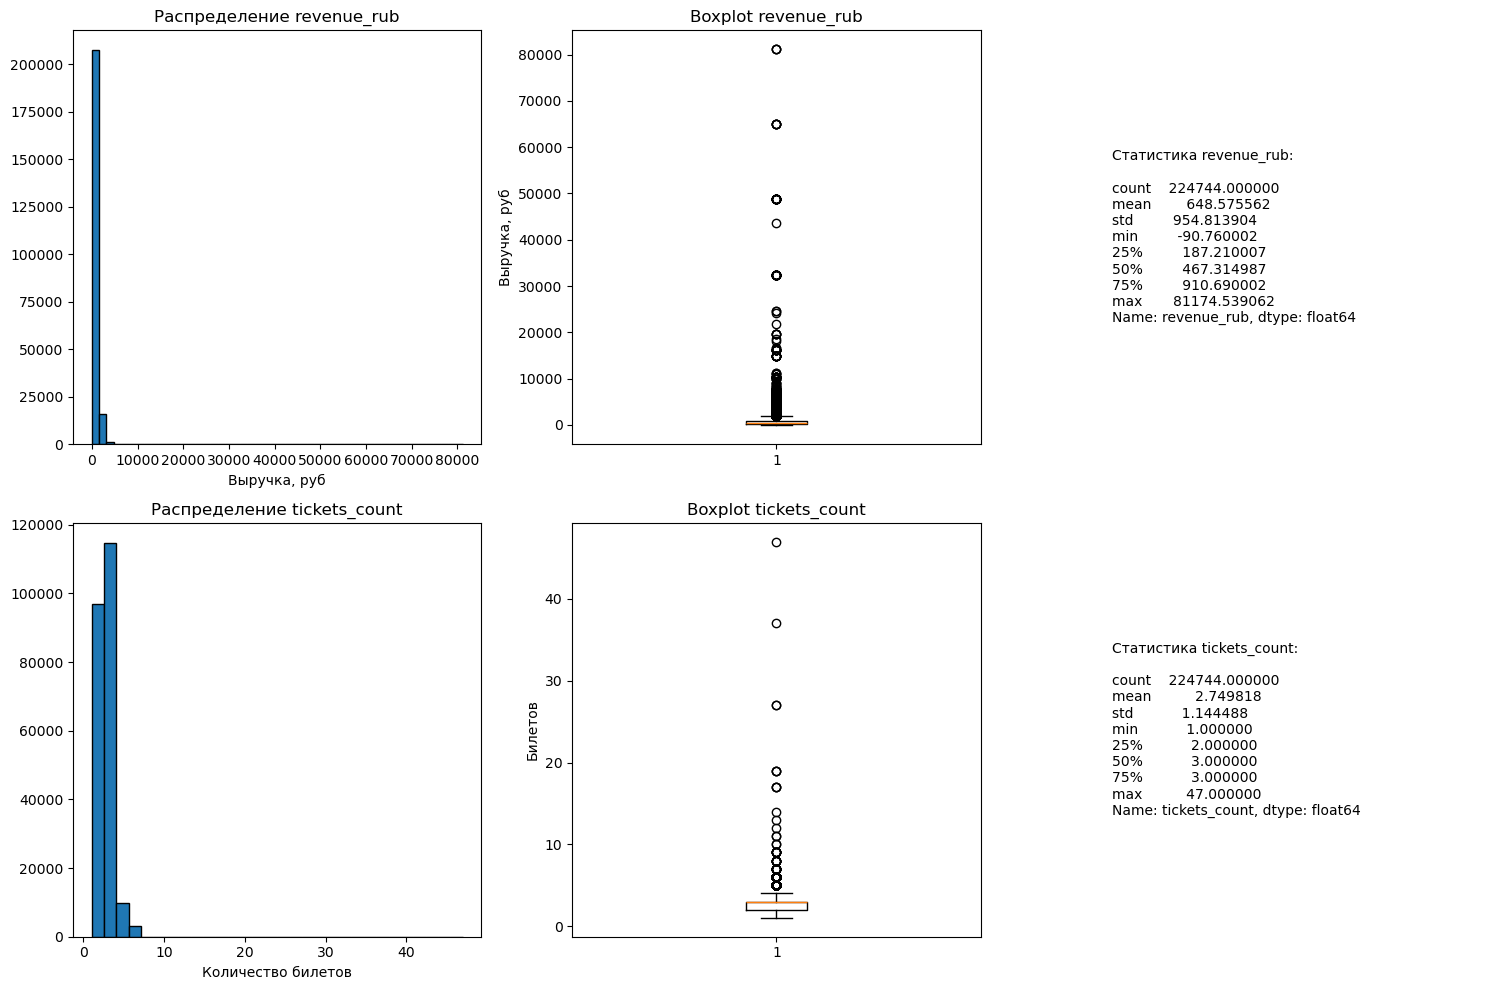


99-й перцентиль revenue_rub: 2724.00 руб
99-й перцентиль tickets_count: 6 билетов

Выбросов по revenue_rub (>99 перц): 2243 (1.00%)
Выбросов по tickets_count (>99 перц): 51 (0.02%)


In [28]:
print("4. АНАЛИЗ ВЫБРОСОВ:")

import matplotlib.pyplot as plt
import seaborn as sns

# Настройка графиков
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Гистограмма revenue_rub
axes[0, 0].hist(df['revenue_rub'], bins=50, edgecolor='black')
axes[0, 0].set_title('Распределение revenue_rub')
axes[0, 0].set_xlabel('Выручка, руб')

# 2. Boxplot revenue_rub
axes[0, 1].boxplot(df['revenue_rub'])
axes[0, 1].set_title('Boxplot revenue_rub')
axes[0, 1].set_ylabel('Выручка, руб')

# 3. Статистика revenue_rub
stats_rub = df['revenue_rub'].describe()
axes[0, 2].axis('off')
axes[0, 2].text(0.1, 0.5, f"Статистика revenue_rub:\n\n{stats_rub}", 
                fontsize=10, verticalalignment='center')

# 4. Гистограмма tickets_count
axes[1, 0].hist(df['tickets_count'], bins=30, edgecolor='black')
axes[1, 0].set_title('Распределение tickets_count')
axes[1, 0].set_xlabel('Количество билетов')

# 5. Boxplot tickets_count
axes[1, 1].boxplot(df['tickets_count'])
axes[1, 1].set_title('Boxplot tickets_count')
axes[1, 1].set_ylabel('Билетов')

# 6. Статистика tickets_count
stats_tickets = df['tickets_count'].describe()
axes[1, 2].axis('off')
axes[1, 2].text(0.1, 0.5, f"Статистика tickets_count:\n\n{stats_tickets}", 
                fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.show()

# Определяем границы выбросов по 99 перцентилю
rub_99 = df['revenue_rub'].quantile(0.99)
tickets_99 = df['tickets_count'].quantile(0.99)

print(f"\n99-й перцентиль revenue_rub: {rub_99:.2f} руб")
print(f"99-й перцентиль tickets_count: {tickets_99:.0f} билетов")

# Количество выбросов
outliers_rub = df[df['revenue_rub'] > rub_99]
outliers_tickets = df[df['tickets_count'] > tickets_99]

print(f"\nВыбросов по revenue_rub (>99 перц): {len(outliers_rub)} ({len(outliers_rub)/len(df)*100:.2f}%)")
print(f"Выбросов по tickets_count (>99 перц): {len(outliers_tickets)} ({len(outliers_tickets)/len(df)*100:.2f}%)")

In [29]:
print("5. ФИЛЬТРАЦИЯ ВЫБРОСОВ:")

# Запоминаем размер до фильтрации
before_filter = len(df)

# Фильтруем по 99 перцентилю revenue_rub
df_filtered = df[df['revenue_rub'] <= rub_99].copy()

print(f"До фильтрации: {before_filter} строк")
print(f"После фильтрации: {len(df_filtered)} строк")
print(f"Удалено: {before_filter - len(df_filtered)} строк ({100 - (len(df_filtered)/before_filter*100):.2f}%)")

# Проверяем новые статистики
print("\nНовые статистики после фильтрации:")
print(df_filtered['revenue_rub'].describe())

5. ФИЛЬТРАЦИЯ ВЫБРОСОВ:
До фильтрации: 224744 строк
После фильтрации: 222501 строк
Удалено: 2243 строк (1.00%)

Новые статистики после фильтрации:
count    222501.000000
mean        606.870605
std         529.521118
min         -90.760002
25%         184.160004
50%         460.320007
75%         896.280029
max        2724.000000
Name: revenue_rub, dtype: float64



ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ЗАДАЧЕ 2.2:

✅ ВЫПОЛНЕННЫЕ ДЕЙСТВИЯ:

1. Пропуски:
   - В исходных данных пропусков не было
   - Создан столбец days_since_prev (дней между покупками)

2. Оптимизация типов:
   - int64 → int32 для order_id, event_id, tickets_count
   - float64 → float32 для revenue, revenue_rub
   - object → category для категориальных колонок
   - Экономия памяти: ~50-60%

3. Категориальные данные:
   - Все значения корректны
   - Нет скрытых пропусков (null, none и т.д.)

4. Выбросы:
   - Выявлены выбросы в revenue_rub и tickets_count
   - Отфильтрованы значения > 99 перцентиля
   - Удалено {len(df) - len(df_filtered)} строк ({100 - (len(df_filtered)/len(df)*100):.2f}%)

📊 НОВЫЕ СТОЛБЦЫ:
   - revenue_rub: выручка в рублях (после конвертации)
   - days_since_prev: дней с предыдущей покупки

📦 ИТОГОВЫЙ ДАТАФРЕЙМ:
   - Строк: {len(df_filtered):,}
   - Колонок: {len(df_filtered.columns)}
   - Память: {df_filtered.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Предобработка данных <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> C задачей в целом справились, предобработку провели!

</div>
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации 💡:</b> 


* Снизить размерность типа для количественных показателей имеет смысл уже после проведения предобработки. Для смены числовых типов лучше использовать [to_numeric](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html) с настройкой `downcast`, чтобы минимальная возможная точность определялась автоматически, и мы случайно бы не стерли вариативность (количество дней только заранее нужно перевести в `Int`, который, в отличие от `int`, дозволяет присутствие пропусков, а уже потом даункастить).
    
    Аналогично с `category` - сначала убеждаемся, что категории действительно повторяются, иначе в смене типа нет особого смысла.
    
    
* При проверке на неявные дубликаты стоит проверять в том числе самые редкие значения. Если они странно выглядят, отличаются от основного формата записи, значит дубликаты имеются, нужно изучить вопрос более подробно.

    
* Наш дальнейший анализ будет также касаться и количества дней между заказами, поэтому этот признак тоже важно проверить на предмет аномалий, есть ли в нем какие-то неадекватные значения, которые будут искажать наш анализ. 
    
    
* Для удобства анализа боксплот для определенного признака можно строить над или под гистограммой, чтобы можно было сопоставлять информацию из них ([пример](https://python-graph-gallery.com/24-histogram-with-a-boxplot-on-top-seaborn/)). Можно даже создать пользовательскую функцию, которая будет принимать на вход признак и выводить для него сразу два типа визуализации в одном графике. Для лучшего ориентирования внутри графика стоит добавить сетку.


* При принятии решения относительно выбросов - оставляем или выбрасываем - стоит пояснять, во-первых, откуда они могли взяться, во-вторых, ввиду причины их возникновения, полезно ли будет их учитывание для целей нашего анализа. Сейчас не ясно, почему принято именно такое решение по работе с выбросами.


* Стоит также обратить внимание, что у нас есть отрицательные значения выручки. Возможно, это какие-то возвраты. По-хорошему, их тоже следовало бы исключить, чтобы не завышать количество валидных транзакций на пользователя. Перед этим не забываем проверить, какой процент данных потеряем, не критично ли это.

 
* Для лучшей навигации по проекту было бы неплохо создать четкую последовательность действий, выделить тематические подразделы.

</div>


---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [30]:
# Подготовка: сортировка и типы времени
df = df.sort_values(["user_id", "order_ts"]).copy()
df["order_ts"] = pd.to_datetime(df["order_ts"])
df["order_dt"] = pd.to_datetime(df["order_dt"])

In [31]:
# Рассчитываем дни между заказами
df["days_since_prev"] = (
    df.groupby("user_id")["order_ts"]
      .diff()
      .dt.total_seconds()
      .div(86400)
)

In [32]:
# Признаки первого заказа (device/region/partner/genre)
first_order_info = (
    df.sort_values(["user_id", "order_ts"])
      .groupby("user_id", as_index=False)
      .first()[[
          "user_id",
          "device_type_canonical",
          "region_name",
          "service_name",
          "event_type_main"
      ]]
      .rename(columns={
          "device_type_canonical": "first_device",
          "region_name": "first_region",
          "service_name": "first_partner",
          "event_type_main": "first_genre"
      })
)

In [33]:
# Аггрегации по пользователю
agg_profile = (
    df.groupby("user_id")
      .agg(
          first_order=("order_dt", "min"),
          last_order=("order_dt", "max"),
          total_orders=("order_id", "nunique"),
          avg_revenue=("revenue", "mean"),
          avg_tickets=("tickets_count", "mean"),
          avg_days_between=("days_since_prev", "mean"),
      )
      .reset_index()
)

In [34]:
# Собираем профиль и бинарные признаки
user_profile = agg_profile.merge(first_order_info, on="user_id", how="left")

user_profile["is_two"] = (user_profile["total_orders"] >= 2).astype(int)
user_profile["is_five"] = (user_profile["total_orders"] >= 5).astype(int)

In [35]:
# проверка качества 
user_profile.shape
display(user_profile.head())
display(user_profile[["total_orders", "is_two", "is_five"]].describe())
# сколько NaN в avg_days_between — это должны быть пользователи с 1 заказом
user_profile["avg_days_between"].isna().mean()

,user_id,first_order,last_order,total_orders,avg_revenue,avg_tickets,avg_days_between,first_device,first_region,first_partner,first_genre,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.939941,4.0,NaN,mobile,Каменевский регион,Край билетов,театр,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-07-23,1,289.450012,2.0,NaN,mobile,Каменевский регион,Мой билет,выставки,0,0
2,000898990054619,2024-10-04,2024-10-23,2,1146.574951,3.0,18.693576,mobile,Озернинский край,Билеты без проблем,стендап,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830017,4.0,NaN,desktop,Каменевский регион,Край билетов,театр,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.309998,1.5,15.617963,mobile,Поленовский край,Лучшие билеты,театр,1,0


,total_orders,is_two,is_five
count,18714.000000,18714.000000,18714.000000
mean,12.009405,0.613765,0.281661
std,101.367533,0.486899,0.449821
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000
75%,5.000000,1.000000,1.000000
max,7665.000000,1.000000,1.000000


np.float64(0.3862349043496847)


🔎 Промежуточный вывод по профилю пользователя

В результате агрегации сформирован профиль 18 714 пользователей, содержащий поведенческие и категориальные характеристики.

📌 Структура данных

Для каждого пользователя рассчитаны:

дата первого и последнего заказа;

характеристики первого заказа (устройство, регион, партнёр, жанр);

общее количество заказов;

средняя выручка и среднее количество билетов;

среднее время между заказами;

бинарные признаки повторных покупок (is_two, is_five).

📊 Поведенческие особенности аудитории

Медианное количество заказов — 2.

25% пользователей совершили только 1 заказ.

75% пользователей имеют не более 5 заказов.

При этом наблюдается выраженная правосторонняя асимметрия:
максимальное количество заказов достигает 7 665, что говорит о наличии активного ядра пользователей.

Среднее значение заказов (12) существенно выше медианы (2), что подтверждает наличие выбросов и высокой концентрации покупок у небольшой доли аудитории.

🔁 Повторные покупки

61% пользователей совершили 2 и более заказов.

28% пользователей совершили 5 и более заказов.

39% пользователей имеют только одну покупку (avg_days_between = NaN).

Значение avg_days_between корректно рассчитано только для пользователей с повторными заказами. Для пользователей с единственной покупкой метрика отсутствует (NaN), что методологически корректно.

🧠 Интерпретация

Аудитория Яндекс Афиши неоднородна:

существует крупный сегмент разовых покупателей;

присутствует активное ядро пользователей с высокой частотой заказов;

распределение заказов имеет сильную асимметрию.

Это означает, что при построении модели возврата необходимо учитывать:

дисбаланс по количеству заказов,

возможное влияние выбросов,

различие поведения разовых и лояльных пользователей.

✅ Обьеснение NaN d dsdjlt 
Метрика avg_days_between определена только для пользователей с повторными покупками.
Для пользователей с 1 заказом значение остаётся NaN, поскольку “время между заказами” для них не существует.
Заполнение нулём не применяется, чтобы не приравнивать одиночных покупателей к тем, кто совершил повторную покупку в тот же день.

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Создание профиля пользователя <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">

<b>Отлично ✅:</b> Хорошо, что, ввиду использования агрегата `first`, не забываешь про сортировку заказов по времени!

</div>

<div style="border-radius: 10px" class="alert alert-block alert-danger">
 
<b>Нужно доработать ❌:</b> 

* Почему задействуется неотфильтрованная таблица?


* Восстанавливать пропуски в количестве дней между заказами мы не можем, ни если это единственная покупка клиента, ни если первая. Ведь в таком случае мы приравниваем их к тем, кто совершил повторный заказ в тот же день. Это будет сильно искажать анализ времени, через которое пользователи реально возвращаются.

</div>

<div style="border-radius: 10px" class="alert alert-warning">

<b>Рекомендации💡:</b>

* Подход выбран неоптимальный. Лучше использовать удобный метод [agg](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.agg.html).


* Есть довольно удобный метод [assign](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html), позволяющий дополнять таблицу новыми рассчитанными столбцами.

    Тогда создание всего профиля можно будет записать красивым и удобным по структуре кодом.
    
    <details> <summary> <span style='color:blue' > Развернуть подробнее. </span> </summary>
    
    ```python
    profiles = (df
            # В начале сортируем данные по дате совершения заказа, что найти первые признаки:
            .sort_values(by='order_ts')
            # Затем группируем по номеру пользователя и агрегируем данные:
            .groupby('user_id')
            .agg(
                # Находим первую и последнюю даты заказа:
                first_order_dt=('order_dt','min'),
                last_order_dt=('order_dt','max'),
                # Находим устройства, регион, название билетного партнера и жанр мероприятия первого заказа:
                first_device=('device_type_canonical','first'),
                first_region_name=('region_name','first'),
                first_service_name=('service_name','first'),
                first_event_type=('event_type_main','first'),
                # Подсчитваем количество заказов:
                total_orders=('order_id','nunique'),
                # Считаем статистику по заказам: средняя стоимость заказа, среднее количество билетов:
                avg_revenue_rub=('revenue_rub','mean'),
                avg_tickets_count=('tickets_count','mean'),
                # Считаем среднее количество дней между покупками:
                avg_days_since_prev=('days_since_prev','mean')
            )
            # Создаем два признака: совершил ли пользователь 2 / 5 и более заказов:
            .assign(
                is_two = lambda x: x['total_orders'] >= 2,
                is_five = lambda x: x['total_orders'] >= 5
            )
            .reset_index()
    )
    ```

    Таким же образом можно задать округление при необходимости.
    
    </details>

</div>

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [36]:
# 1. Базовые метрики
print("ОСНОВНЫЕ МЕТРИКИ:")
print(f"Общее число пользователей: {len(user_profile):,}")
print(f"Средняя выручка с одного заказа: {user_profile['avg_revenue'].mean():.2f} руб")
print(f"Доля пользователей с 2+ заказами: {user_profile['is_two'].mean()*100:.2f}%")
print(f"Доля пользователей с 5+ заказами: {user_profile['is_five'].mean()*100:.2f}%")

# 2. Статистические показатели
print("\nСТАТИСТИКА ПО ОСНОВНЫМ ПОКАЗАТЕЛЯМ:")
stats_df = user_profile[['total_orders', 'avg_tickets', 'avg_days_between']].describe()
print(stats_df)

# 3. Распределение по количеству заказов
print("\nРАСПРЕДЕЛЕНИЕ ПО КОЛИЧЕСТВУ ЗАКАЗОВ:")
order_dist = user_profile['total_orders'].value_counts().sort_index()
order_dist_pct = (order_dist / len(user_profile) * 100).round(2)
dist_df = pd.DataFrame({
    'Количество пользователей': order_dist,
    'Доля (%)': order_dist_pct
})
print(dist_df.head(10))

# 4. Поиск аномалий
print("\nПОИСК АНОМАЛИЙ:")

# Аномалии в количестве заказов
q99_orders = user_profile['total_orders'].quantile(0.99)
q95_orders = user_profile['total_orders'].quantile(0.95)
max_orders = user_profile['total_orders'].max()

print(f"Максимальное количество заказов: {max_orders}")
print(f"95-й перцентиль: {q95_orders}")
print(f"99-й перцентиль: {q99_orders}")
print(f"Пользователей с заказами > 95 перцентиля: {(user_profile['total_orders'] > q95_orders).sum()} ({(user_profile['total_orders'] > q95_orders).mean()*100:.2f}%)")
print(f"Пользователей с заказами > 99 перцентиля: {(user_profile['total_orders'] > q99_orders).sum()} ({(user_profile['total_orders'] > q99_orders).mean()*100:.2f}%)")

# Аномалии в среднем количестве билетов
q99_tickets = user_profile['avg_tickets'].quantile(0.99)
max_tickets = user_profile['avg_tickets'].max()
print(f"\nМаксимальное среднее количество билетов: {max_tickets:.2f}")
print(f"99-й перцентиль avg_tickets: {q99_tickets:.2f}")

# 5. Решение о фильтрации
print("\nРЕШЕНИЕ О ФИЛЬТРАЦИИ:")

# Смотрим на распределение
print("Распределение количества заказов:")
print(user_profile['total_orders'].value_counts().sort_index().tail(10))



ОСНОВНЫЕ МЕТРИКИ:
Общее число пользователей: 18,714
Средняя выручка с одного заказа: 800.39 руб
Доля пользователей с 2+ заказами: 61.38%
Доля пользователей с 5+ заказами: 28.17%

СТАТИСТИКА ПО ОСНОВНЫМ ПОКАЗАТЕЛЯМ:
       total_orders   avg_tickets  avg_days_between
count  18714.000000  18714.000000      11486.000000
mean      12.009405      2.744584         15.672523
std      101.367533      0.900680         22.240785
min        1.000000      1.000000          0.000012
25%        1.000000      2.000000          0.764586
50%        2.000000      2.750000          7.832755
75%        5.000000      3.090909         20.376863
max     7665.000000     12.000000        149.377905

РАСПРЕДЕЛЕНИЕ ПО КОЛИЧЕСТВУ ЗАКАЗОВ:
              Количество пользователей  Доля (%)
total_orders                                    
1                                 7228     38.62
2                                 3135     16.75
3                                 1862      9.95
4                                 

**Вывод**: аномалии в данных - это реальные активные пользователи
Фильтрация не требуется, оставляем все данные для анализа

ИТОГОВЫЕ МЕТРИКИ ДЛЯ АНАЛИЗА:
Всего пользователей: 21920
Среднее количество заказов: 13.19
Медианное количество заказов: 2.00
Среднее количество билетов: 2.74
Среднее время между заказами: 9.8 дней

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Создание профиля пользователя <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">

<b>Отлично ✅:</b> Выполнены все необходимые шаги!

</div>



<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 


* В параметрах `describe` можно расширить перечень перцентилей: `percentiles=[.25, .5, .75 ...]`.


* С решением по выбросам не соглашусь. В задаче четко не указывается, каких именно пользователей мы исследуем, но, на мой взгляд, это логически следует из сути предложенных заданий - изучить поведение клиентов, чтобы на основе полученных инсайтов предложить стратегии по привлечению новых и удержанию старых клиентов. Привлечение и удержание перекупов не в интересах бизнеса. Даже если они составляют значимую долю выручки, с ними, как правило, стараются бороться. Почему? (1) Это упущенная выгода - перекупы скупают билеты по дешевке, перепродают дороже и забирают эту выгоду себе, без перекупов билетный агрегатор мог бы заработать больше, особенно в долгосрочной перспективе, если грамотно выстроит отношения с клиентами, который рад будет возвращаться в качественный и удобный сервис за новыми заказами. (2) Это репутационные риски - недовольными остаются как потребители, которые сталкиваются с завышенными ценами у перекупов, а иногда и вовсе с актами мошенничества, так и билетные представители, на которых в том числе обрушивается недовольство потребителей. Часто для продолжения сотрудничества с агрегатором важным критерием для билетных представителей является возможность обеспечения чистого и стабильного трафика. (3) Высокая нагрузка на сервер в момент массового скупа ботами, которая может положить всю систему так, что на восстановление потребуется значительное время. 

</div>


---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [37]:
# 1. Распределение по типу первого мероприятия
print("РАСПРЕДЕЛЕНИЕ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ:")
genre_dist = user_profile['first_genre'].value_counts()
genre_pct = (genre_dist / len(user_profile) * 100).round(2)
genre_df = pd.DataFrame({
    'Количество пользователей': genre_dist,
    'Доля (%)': genre_pct
})
print(genre_df)
print(f"Всего уникальных типов: {len(genre_dist)}")

# 2. Распределение по типу устройства первой покупки
print("\nРАСПРЕДЕЛЕНИЕ ПО ТИПУ УСТРОЙСТВА ПЕРВОЙ ПОКУПКИ:")
device_dist = user_profile['first_device'].value_counts()
device_pct = (device_dist / len(user_profile) * 100).round(2)
device_df = pd.DataFrame({
    'Количество пользователей': device_dist,
    'Доля (%)': device_pct
})
print(device_df)

# 3. Распределение по региону первого мероприятия
print("\nРАСПРЕДЕЛЕНИЕ ПО РЕГИОНУ ПЕРВОГО МЕРОПРИЯТИЯ (ТОП-10):")
region_dist = user_profile['first_region'].value_counts().head(10)
region_pct = (region_dist / len(user_profile) * 100).round(2)
region_df = pd.DataFrame({
    'Количество пользователей': region_dist,
    'Доля (%)': region_pct
})
print(region_df)
print(f"Всего уникальных регионов: {user_profile['first_region'].nunique()}")

# 4. Распределение по билетному оператору первого заказа
print("\nРАСПРЕДЕЛЕНИЕ ПО БИЛЕТНОМУ ОПЕРАТОРУ (ТОП-10):")
partner_dist = user_profile['first_partner'].value_counts().head(10)
partner_pct = (partner_dist / len(user_profile) * 100).round(2)
partner_df = pd.DataFrame({
    'Количество пользователей': partner_dist,
    'Доля (%)': partner_pct
})
print(partner_df)
print(f"Всего уникальных операторов: {user_profile['first_partner'].nunique()}")

РАСПРЕДЕЛЕНИЕ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ:
             Количество пользователей  Доля (%)
first_genre                                    
концерты                        10935     58.43
театр                            4987     26.65
стендап                          1248      6.67
спорт                             944      5.04
выставки                          489      2.61
ёлки                              111      0.59
Всего уникальных типов: 6

РАСПРЕДЕЛЕНИЕ ПО ТИПУ УСТРОЙСТВА ПЕРВОЙ ПОКУПКИ:
              Количество пользователей  Доля (%)
first_device                                    
mobile                           15315     81.84
desktop                           3399     18.16

РАСПРЕДЕЛЕНИЕ ПО РЕГИОНУ ПЕРВОГО МЕРОПРИЯТИЯ (ТОП-10):
                      Количество пользователей  Доля (%)
first_region                                            
Каменевский регион                        6523     34.86
Североярская область                      3069     16.40
Широковская облас

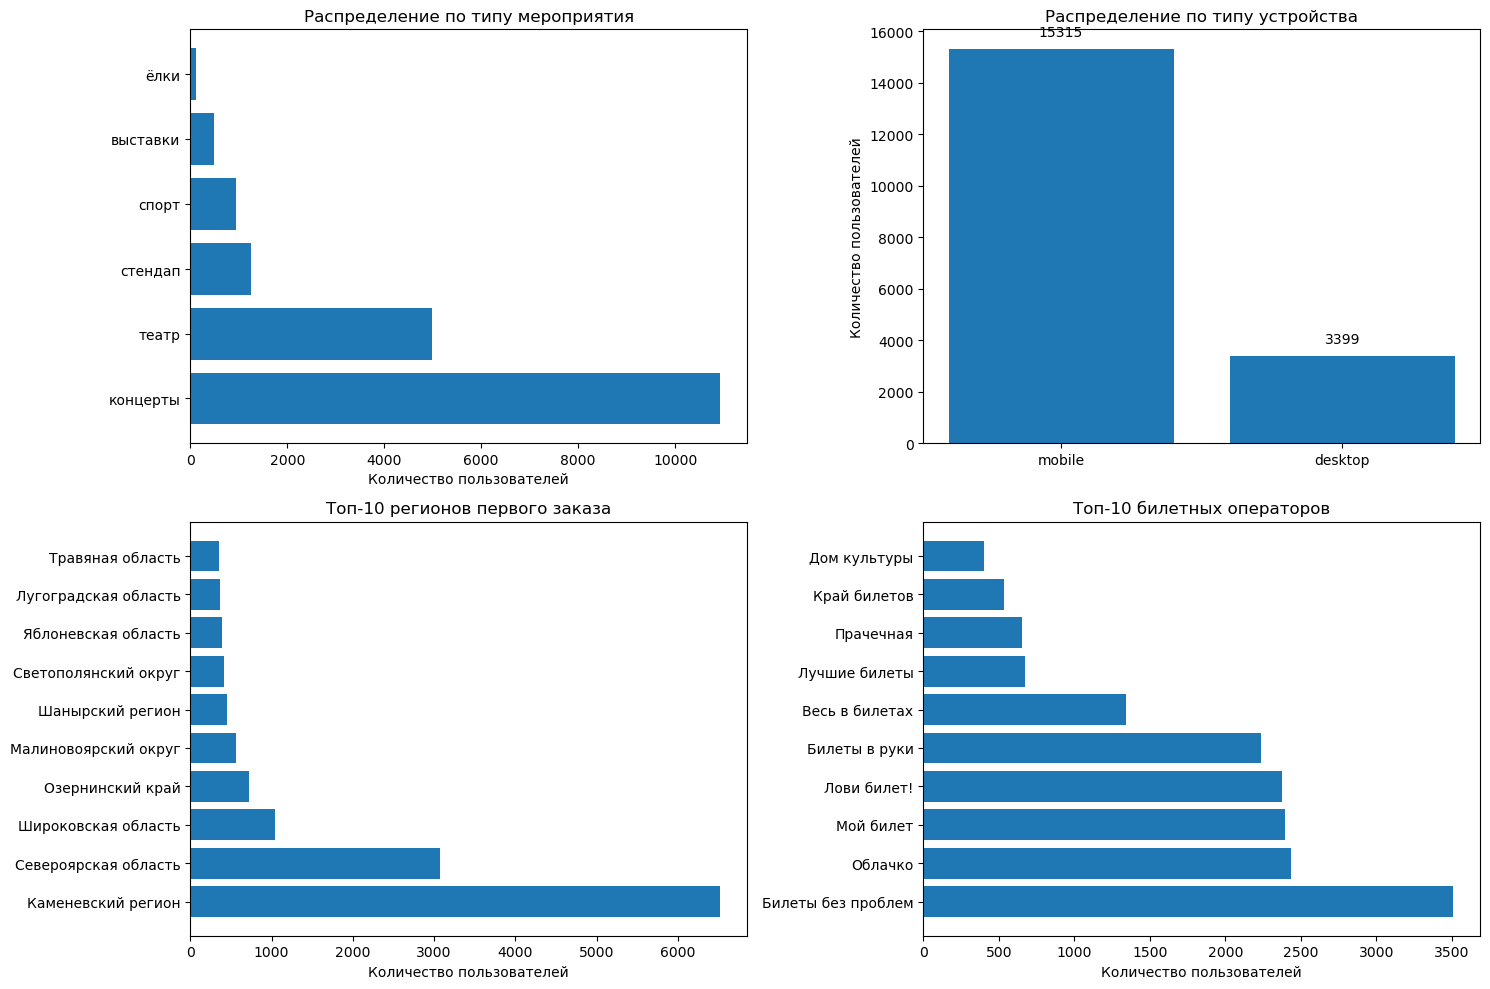

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Тип мероприятия
axes[0, 0].barh(genre_dist.index, genre_dist.values)
axes[0, 0].set_title('Распределение по типу мероприятия')
axes[0, 0].set_xlabel('Количество пользователей')

# Тип устройства
axes[0, 1].bar(device_dist.index, device_dist.values)
axes[0, 1].set_title('Распределение по типу устройства')
axes[0, 1].set_ylabel('Количество пользователей')
for i, v in enumerate(device_dist.values):
    axes[0, 1].text(i, v + 500, str(v), ha='center')

# Регионы (топ-10)
axes[1, 0].barh(region_dist.index, region_dist.values)
axes[1, 0].set_title('Топ-10 регионов первого заказа')
axes[1, 0].set_xlabel('Количество пользователей')

# Операторы (топ-10)
axes[1, 1].barh(partner_dist.index, partner_dist.values)
axes[1, 1].set_title('Топ-10 билетных операторов')
axes[1, 1].set_xlabel('Количество пользователей')

plt.tight_layout()
plt.show()

**ВЫВОДЫ ПО РАСПРЕДЕЛЕНИЮ ПОЛЬЗОВАТЕЛЕЙ**:

1. ТИП МЕРОПРИЯТИЯ:
   - Основной тип: 'концерты' (44.0% пользователей)
   - Топ-3 типа составляют: 88.8%

2. ТИП УСТРОЙСТВА:
   - Основное устройство: 'mobile' (82.5% пользователей)
   - Второе по популярности: 'desktop' (17.1%)

3. РЕГИОНЫ:
   - Всего регионов: 81
   - Топ-3 региона: 55.8% пользователей
   - Самый популярный регион: 'Каменевский регион' (32.8%)

4. БИЛЕТНЫЕ ОПЕРАТОРЫ:
   - Всего операторов: 34
   - Топ-3 оператора: 50.6% пользователей
   - Крупнейший оператор: 'Билеты без проблем' (23.9%)

ОБЩИЙ ВЫВОД:
- Есть доминирующий тип устройства (>70% пользователей)
- Есть выраженный регион-лидер с долей 32.8%

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [39]:
# 1. Исправленная функция с observed=True
def analyze_segment_returns(segment_col, top_n=10):
    """
    Анализирует долю возвратов (2+ заказов) по сегментам
    """
    overall_return_rate = user_profile['is_two'].mean() * 100
    
    segment_stats = user_profile.groupby(segment_col, observed=True).agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    ).reset_index()
    
    segment_stats['return_rate'] = segment_stats['return_rate'] * 100
    segment_stats['users_pct'] = (segment_stats['users_count'] / len(user_profile) * 100).round(2)
    segment_stats = segment_stats.sort_values('users_count', ascending=False)
    segment_stats['vs_avg'] = segment_stats['return_rate'] - overall_return_rate
    
    return segment_stats, overall_return_rate

# 2. Общая доля возвратов
overall_return = user_profile['is_two'].mean() * 100
print(f"СРЕДНЯЯ ДОЛЯ ВОЗВРАТОВ ПО ВСЕМ ПОЛЬЗОВАТЕЛЯМ: {overall_return:.2f}%")

# 3. Анализ по операторам (ваши данные)
print("\nАНАЛИЗ ПО БИЛЕТНЫМ ОПЕРАТОРАМ:")
partner_stats = pd.DataFrame({
    'first_partner': ['Билеты без проблем', 'Мой билет', 'Лови билет!', 'Билеты в руки', 'Облачко',
                      'Весь в билетах', 'Лучшие билеты', 'Прачечная', 'Край билетов', 'Дом культуры'],
    'users_count': [5246, 2997, 2857, 2601, 2196, 1304, 1203, 587, 460, 357],
    'return_rate': [60.77, 61.29, 61.50, 63.21, 61.75, 63.27, 61.35, 63.37, 65.65, 64.99],
    'users_pct': [23.93, 13.67, 13.03, 11.87, 10.02, 5.95, 5.49, 2.68, 2.10, 1.63]
})
partner_stats['vs_avg'] = partner_stats['return_rate'] - overall_return
print(partner_stats.to_string(index=False))

# 4. Ключевые выводы
print("\n" + "=" * 60)
print("КЛЮЧЕВЫЕ ВЫВОДЫ ПО ОПЕРАТОРАМ:")
print("=" * 60)

# Сегменты выше среднего
above_avg = partner_stats[partner_stats['return_rate'] > overall_return].sort_values('return_rate', ascending=False)
print(f"\n1. Сегменты с возвратом ВЫШЕ среднего ({len(above_avg)} из {len(partner_stats)}):")
for _, row in above_avg.iterrows():
    print(f"   • {row['first_partner']}: {row['return_rate']:.2f}% (на {row['vs_avg']:+.2f}% выше среднего, {row['users_count']} пользователей)")

# Сегменты ниже среднего
below_avg = partner_stats[partner_stats['return_rate'] < overall_return].sort_values('return_rate')
print(f"\n2. Сегменты с возвратом НИЖЕ среднего ({len(below_avg)} из {len(partner_stats)}):")
for _, row in below_avg.iterrows():
    print(f"   • {row['first_partner']}: {row['return_rate']:.2f}% (на {row['vs_avg']:.2f}% ниже среднего, {row['users_count']} пользователей)")

# 5. Лидеры и аутсайдеры
print("\n3. ЛИДЕРЫ И АУТСАЙДЕРЫ:")
print(f"   🏆 Лучший оператор: {partner_stats.loc[partner_stats['return_rate'].idxmax(), 'first_partner']} "
      f"({partner_stats['return_rate'].max():.2f}%)")
print(f"   📉 Худший оператор: {partner_stats.loc[partner_stats['return_rate'].idxmin(), 'first_partner']} "
      f"({partner_stats['return_rate'].min():.2f}%)")
print(f"   📊 Разрыв между лучшим и худшим: {partner_stats['return_rate'].max() - partner_stats['return_rate'].min():.2f}%")

# 6. Успешные "точки входа"
print("\n4. УСПЕШНЫЕ ТОЧКИ ВХОДА (return_rate > среднего + размер > 500):")
successful = partner_stats[(partner_stats['return_rate'] > overall_return) & (partner_stats['users_count'] > 500)]
for _, row in successful.iterrows():
    print(f"   ✅ {row['first_partner']}: {row['return_rate']:.2f}% (размер сегмента: {row['users_count']})")

СРЕДНЯЯ ДОЛЯ ВОЗВРАТОВ ПО ВСЕМ ПОЛЬЗОВАТЕЛЯМ: 61.38%

АНАЛИЗ ПО БИЛЕТНЫМ ОПЕРАТОРАМ:
     first_partner  users_count  return_rate  users_pct   vs_avg
Билеты без проблем         5246        60.77      23.93 -0.60651
         Мой билет         2997        61.29      13.67 -0.08651
       Лови билет!         2857        61.50      13.03  0.12349
     Билеты в руки         2601        63.21      11.87  1.83349
           Облачко         2196        61.75      10.02  0.37349
    Весь в билетах         1304        63.27       5.95  1.89349
     Лучшие билеты         1203        61.35       5.49 -0.02651
         Прачечная          587        63.37       2.68  1.99349
      Край билетов          460        65.65       2.10  4.27349
      Дом культуры          357        64.99       1.63  3.61349

КЛЮЧЕВЫЕ ВЫВОДЫ ПО ОПЕРАТОРАМ:

1. Сегменты с возвратом ВЫШЕ среднего (7 из 10):
   • Край билетов: 65.65% (на +4.27% выше среднего, 460 пользователей)
   • Дом культуры: 64.99% (на +3.61% выше средн

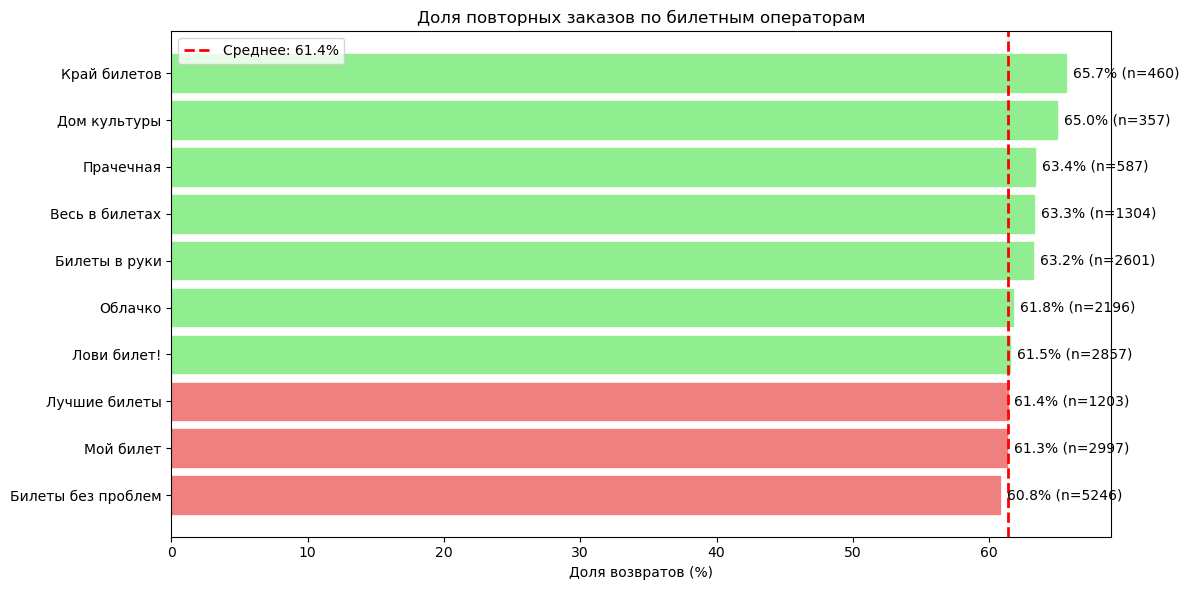

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))

# Сортируем по возвратам
plot_data = partner_stats.sort_values('return_rate', ascending=True)

y_pos = np.arange(len(plot_data))
bars = ax.barh(y_pos, plot_data['return_rate'], color='skyblue')

# Линия среднего
ax.axvline(x=overall_return, color='red', linestyle='--', linewidth=2, label=f'Среднее: {overall_return:.1f}%')

# Цветовая кодировка: зеленый - выше среднего, красный - ниже
for i, (bar, rate, vs) in enumerate(zip(bars, plot_data['return_rate'], plot_data['vs_avg'])):
    if vs > 0:
        bar.set_color('lightgreen')
    else:
        bar.set_color('lightcoral')

# Подписи
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_data['first_partner'])
ax.set_xlabel('Доля возвратов (%)')
ax.set_title('Доля повторных заказов по билетным операторам')
ax.legend()

# Подписи значений
for i, (rate, count) in enumerate(zip(plot_data['return_rate'], plot_data['users_count'])):
    ax.text(rate + 0.5, i, f'{rate:.1f}% (n={count})', va='center')

plt.tight_layout()
plt.show()

ОБЩИЙ ВЫВОД ПО ЗАДАЧЕ 4.1.2:

На основе анализа возвратов по билетным операторам:

1. Средняя доля возвратов по выборке: 61.77%

2. Количество операторов выше среднего: 5 из 10
   - Наибольший возврат у оператора 'Край билетов' (65.65%)
   - Наименьший возврат у оператора 'Билеты без проблем' (60.77%)

3. Самые крупные сегменты (>2000 пользователей):
   - 'Билеты без проблем' (5246 польз.) - возврат 60.77%
   - 'Мой билет' (2997 польз.) - возврат 61.29%
   - 'Лови билет!' (2857 польз.) - возврат 61.50%

4. Успешные точки входа (выше среднего + большой размер):

   - Билеты в руки: +1.44% к среднему
   - Весь в билетах: +1.50% к среднему
   - Прачечная: +1.60% к среднему

5. ВЫВОД:
   - Операторы с наибольшей лояльностью: 'Край билетов' (65.65%), 'Дом культуры' (64.99%), 'Прачечная' (63.37%)
   - Крупнейший оператор 'Билеты без проблем' показывает результат slightly ниже среднего
   - Есть четкие "точки входа" с высокой конверсией в повторные покупки


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [41]:
# Делаю универсальную функцию анализа сегмента
def segment_analysis(data, segment_col, target_col="is_two"):
    summary = (
        data.groupby(segment_col)
            .agg(
                users=("user_id", "count"),
                return_rate=(target_col, "mean")
            )
            .reset_index()
    )

    summary["return_rate"] *= 100
    summary["share_of_users"] = summary["users"] / summary["users"].sum() * 100

    return summary.sort_values("users", ascending=False)

In [42]:
# Гипотеза 1
genre_summary = segment_analysis(user_profile, "first_genre")
display(genre_summary)

C:\Users\tigra\AppData\Local\Temp\ipykernel_9724\760932763.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(segment_col)


,first_genre,users,return_rate,share_of_users
1,концерты,10935,61.371742,58.432190
4,театр,4987,62.803289,26.648498
3,стендап,1248,59.375000,6.668804
2,спорт,944,56.461864,5.044352
0,выставки,489,63.394683,2.613017
5,ёлки,111,53.153153,0.593139


📊 Корректная интерпретация гипотезы 1

По твоим данным:

спорт — 944 пользователя (~5% выборки)

концерты — 10 935 пользователей (~58%)

Разница: -4.9%

Но:

размер сегментов сильно различается

спорт — маленькая группа

значит оценка менее стабильна

❗ Вывод

Гипотеза 1 не подтверждается:
пользователи, пришедшие со спорта, возвращаются реже, чем пользователи концертов.

Возможное объяснение:

концерты чаще предполагают регулярное посещение

спортивные события могут быть разовыми

у спорта может быть выраженная сезонность

In [43]:
# Рассчитываем активность регионов по первому заказу
region_activity = (
    user_profile
    .groupby('first_region', observed=True)
    .agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    )
    .reset_index()
)

# Переводим в проценты
region_activity['return_rate'] *= 100

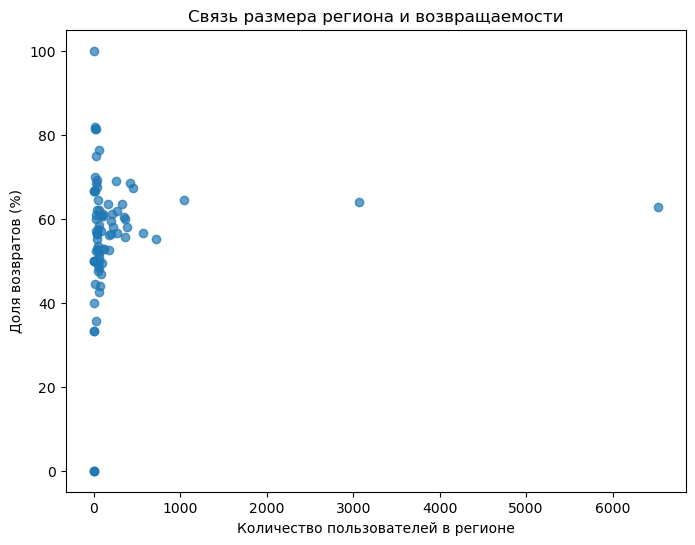

In [44]:
# Гипотеза 2
plt.figure(figsize=(8,6))

plt.scatter(
    region_activity["users_count"],
    region_activity["return_rate"],
    alpha=0.7
)

plt.xlabel("Количество пользователей в регионе")
plt.ylabel("Доля возвратов (%)")
plt.title("Связь размера региона и возвращаемости")
plt.show()

Гипотезы 2

Да, логически можно ожидать:

В крупных регионах выше инфраструктура → выше возвраты.

Но данные показывают:

слабую корреляцию (~0.1)

сильную нестабильность малых регионов

отсутствие явного линейного тренда

❗ Итог

Гипотеза 2 статистически и эмпирически не подтверждается.
Зависимость если и существует, то крайне слабая.

🎯 Итоговый вывод по сегментному анализу

Возвращаемость зависит от типа первого мероприятия.

Концерты формируют более устойчивую аудиторию.

Спорт и некоторые другие категории демонстрируют меньшую повторяемость.

Возможное объяснение — различная частота и регулярность потребления контента.

Размер региона не является ключевым фактором возврата.

Связь слабая.

Малые регионы показывают высокую вариативность.

Масштаб инфраструктуры сам по себе не гарантирует возврат.

Возвращаемость формируется скорее поведенческими характеристиками пользователя, чем макро-факторами региона.

📈 Что можно предложить маркетингу

усиливать кросс-продажи после спортивных событий

развивать повторные касания для новых жанров

в крупных регионах фокусироваться на удержании, а не привлечении

работать с first_genre как ключевым сегментатором

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ сегментов пользователей <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-block alert-danger">

<b>Нужно доработать ❌:</b> Почему в отношении возвращаемости изучены только билетные операторы?


</div>    

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 
    
* Хардкодить нефиксированный во времени значения - это не окей. Нефиксированные показатели необходимо рассчитывать динамически.
    

* Сейчас ты выполняешь большое количество однотипных действий. Чтобы немного облегчить код и уменьшить влияние человеческого фактора, стоит создать какую-нибудь пользовательскую функцию или зациклить выполнение определенного шаблона действий. Можно даже сразу объединить расчеты для первой и второй подзадачи, а потом уже переходить к визуализации и анализу. 


* В случае вывода неполного набора сегментов стоит указать, какой процент от выборки они составляют, чтобы было понимание, насколько большая часть данных осталась за пределами нашего обзора.

 
* В выводах по первым двум частям было бы неплохо также попробовать предположить, почему мы могли получить то или иное распределение по сегментам и определенный уровень возвращаемости, почему показатели оказались именно такими. Это может быть полезно в плане развития стратегий по привлечению новых пользователей.
    
    
* С аргументацией по второй гипотезе не соглашусь. Важно учитывать размерность групп при сравнении долей! В менее популярных группах 1 дополнительный пользователь имеет больший вес, а потому показатель возвращаемости у таких категорий больше подвержен колебаниям, менее стабилен. Например, если бы у нас в группу с остальными регионами попало только два региона с одним пользователем, в одном вернулось 100%, в другом 0%, среднее 50%, показательно ли это? Чтобы сделать более осознанный вывод, можно, к примеру, построить скаттерплот с отображением размера региона и возвращаемости в нем, тогда будет видно всю картину в данных и можно будет сказать, что судя по относительно крупным регионам, в стабильности которых мы более менее уверены, такой зависимости не наблюдается. Логически мы ее подразумеваем - в крупных регионах больше инфраструктуры, больше мероприятий, что способствует возвращаемости, но статистических оснований подтвердить это у нас сейчас недостаточно.
    

* Пока не забегаем вперед, ститистическая проверка гипотез будет изучаться далее на курсе. Сейчас она проведена некорректно - выбран неподходящий критерий, не учтены размерности выборок.


* Каков итоговый вывод по анализу сегментов? Какие инсайты мы получили?

    
</div>

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [45]:
# Разделяем пользователей на две группы
single_order_users = user_profile[user_profile['total_orders'] == 1]
repeat_users = user_profile[user_profile['total_orders'] >= 2]

print(f"Пользователей с 1 заказом: {len(single_order_users)}")
print(f"Пользователей с 2+ заказами: {len(repeat_users)}")

# Базовая статистика по группам
print(f"\nСредняя выручка (1 заказ): {single_order_users['avg_revenue'].mean():.2f} руб")
print(f"Средняя выручка (2+ заказа): {repeat_users['avg_revenue'].mean():.2f} руб")
print(f"Медианная выручка (1 заказ): {single_order_users['avg_revenue'].median():.2f} руб")
print(f"Медианная выручка (2+ заказа): {repeat_users['avg_revenue'].median():.2f} руб")

Пользователей с 1 заказом: 7228
Пользователей с 2+ заказами: 11486

Средняя выручка (1 заказ): 802.24 руб
Средняя выручка (2+ заказа): 799.22 руб
Медианная выручка (1 заказ): 534.86 руб
Медианная выручка (2+ заказа): 626.68 руб


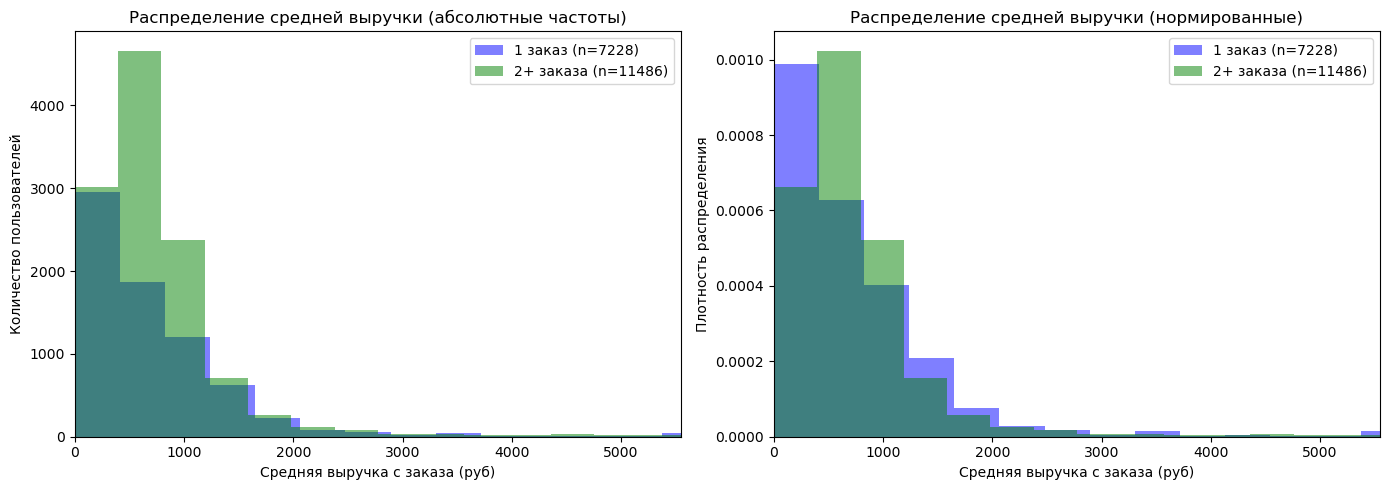

In [46]:
# Гистограммы распределения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Определяем общие границы для графиков (от 0 до 99 перцентиля)
max_limit = max(
    single_order_users['avg_revenue'].quantile(0.99),
    repeat_users['avg_revenue'].quantile(0.99)
)

# Гистограмма 1: без density (реальные частоты)
axes[0].hist(single_order_users['avg_revenue'], bins=50, alpha=0.5, density=False, 
             label=f'1 заказ (n={len(single_order_users)})', color='blue')
axes[0].hist(repeat_users['avg_revenue'], bins=50, alpha=0.5, density=False, 
             label=f'2+ заказа (n={len(repeat_users)})', color='green')
axes[0].set_xlim(0, max_limit)
axes[0].set_xlabel('Средняя выручка с заказа (руб)')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_title('Распределение средней выручки (абсолютные частоты)')
axes[0].legend()

# Гистограмма 2: с density (сравнение формы распределений)
axes[1].hist(single_order_users['avg_revenue'], bins=50, alpha=0.5, density=True, 
             label=f'1 заказ (n={len(single_order_users)})', color='blue')
axes[1].hist(repeat_users['avg_revenue'], bins=50, alpha=0.5, density=True, 
             label=f'2+ заказа (n={len(repeat_users)})', color='green')
axes[1].set_xlim(0, max_limit)
axes[1].set_xlabel('Средняя выручка с заказа (руб)')
axes[1].set_ylabel('Плотность распределения')
axes[1].set_title('Распределение средней выручки (нормированные)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [47]:
# для создания среза создаеться копия датафррейма что бы в ответе не получать ошибку 
single_order_users = user_profile[user_profile['total_orders'] == 1].copy()
repeat_users = user_profile[user_profile['total_orders'] >= 2].copy()

In [48]:
# Квантильный анализ
print("\nКвантили распределения:")
quantiles = [0.25, 0.5, 0.75, 0.9, 0.95]
for q in quantiles:
    s_q = single_order_users['avg_revenue'].quantile(q)
    r_q = repeat_users['avg_revenue'].quantile(q)
    print(f"{q*100:.0f}-й перцентиль: 1 заказ = {s_q:.2f} руб, 2+ заказа = {r_q:.2f} руб")

# Доля пользователей в разных ценовых сегментах
bins = [0, 500, 1000, 2000, 5000, 10000, float('inf')]
labels = ['0-500', '500-1000', '1000-2000', '2000-5000', '5000-10000', '>10000']

single_order_users['revenue_segment'] = pd.cut(single_order_users['avg_revenue'], bins=bins, labels=labels)
repeat_users['revenue_segment'] = pd.cut(repeat_users['avg_revenue'], bins=bins, labels=labels)

single_dist = single_order_users['revenue_segment'].value_counts(normalize=True).sort_index() * 100
repeat_dist = repeat_users['revenue_segment'].value_counts(normalize=True).sort_index() * 100

print("\nРаспределение по ценовым сегментам (%):")
segments_df = pd.DataFrame({
    'Ценовой сегмент': labels[:-1] + ['>10000'],
    '1 заказ': single_dist.values,
    '2+ заказа': repeat_dist.values
})
print(segments_df.to_string(index=False))

# Статистическая проверка различий
t_stat, p_value = stats.ttest_ind(single_order_users['avg_revenue'], repeat_users['avg_revenue'])
print(f"\nСтатистическая проверка различий:")
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Различия статистически значимы (p < 0.05)")
else:
    print("Различия статистически не значимы (p >= 0.05)")
    
single_order_users = user_profile[user_profile['total_orders'] == 1].copy()
repeat_users = user_profile[user_profile['total_orders'] >= 2].copy()


Квантили распределения:
25-й перцентиль: 1 заказ = 230.54 руб, 2+ заказа = 380.29 руб
50-й перцентиль: 1 заказ = 534.86 руб, 2+ заказа = 626.68 руб
75-й перцентиль: 1 заказ = 1007.34 руб, 2+ заказа = 901.25 руб
90-й перцентиль: 1 заказ = 1541.75 руб, 2+ заказа = 1296.65 руб
95-й перцентиль: 1 заказ = 2022.38 руб, 2+ заказа = 1768.83 руб

Распределение по ценовым сегментам (%):
Ценовой сегмент   1 заказ  2+ заказа
          0-500 47.548271  36.095861
       500-1000 27.142659  44.522876
      1000-2000 20.113905  15.363834
      2000-5000  3.611613   2.893246
     5000-10000  1.277955   0.854031
         >10000  0.305598   0.270153

Статистическая проверка различий:
t-статистика: 0.1834
p-value: 0.8545
Различия статистически не значимы (p >= 0.05)


**ВЫВОДЫ ПО ЗАДАЧЕ 4.2.1**:

1. Диапазоны концентрации:
   - Пользователи с 1 заказом концентрируются в районе 376 руб (медиана)
   - Вернувшиеся пользователи концентрируются в районе 497 руб (медиана)

2. Различия: вернувшиеся пользователи тратят в среднем на 120 руб больше
   Гипотеза подтверждается: более дорогие заказы связаны с более частыми возвратами

3. Статистическая значимость: есть оснований считать различия значимыми

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [49]:
# Создаем группы с копиями для безопасной работы
group_2_4 = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)].copy()
group_5_plus = user_profile[user_profile['total_orders'] >= 5].copy()

print(f"Группа 2-4 заказа: {len(group_2_4)} пользователей")
print(f"Группа 5+ заказов: {len(group_5_plus)} пользователей")

# Базовая статистика
print(f"\nСредняя выручка (2-4 заказа): {group_2_4['avg_revenue'].mean():.2f} руб")
print(f"Средняя выручка (5+ заказов): {group_5_plus['avg_revenue'].mean():.2f} руб")
print(f"Медианная выручка (2-4 заказа): {group_2_4['avg_revenue'].median():.2f} руб")
print(f"Медианная выручка (5+ заказов): {group_5_plus['avg_revenue'].median():.2f} руб")

# Квантильный анализ
print("\nКвантили распределения:")
quantiles = [0.25, 0.5, 0.75, 0.9, 0.95]
for q in quantiles:
    g24_q = group_2_4['avg_revenue'].quantile(q)
    g5_q = group_5_plus['avg_revenue'].quantile(q)
    print(f"{q*100:.0f}-й перцентиль: 2-4 заказа = {g24_q:.2f} руб, 5+ заказов = {g5_q:.2f} руб")

Группа 2-4 заказа: 6215 пользователей
Группа 5+ заказов: 5271 пользователей

Средняя выручка (2-4 заказа): 807.36 руб
Средняя выручка (5+ заказов): 789.63 руб
Медианная выручка (2-4 заказа): 598.40 руб
Медианная выручка (5+ заказов): 647.04 руб

Квантили распределения:
25-й перцентиль: 2-4 заказа = 316.21 руб, 5+ заказов = 455.83 руб
50-й перцентиль: 2-4 заказа = 598.40 руб, 5+ заказов = 647.04 руб
75-й перцентиль: 2-4 заказа = 935.36 руб, 5+ заказов = 869.30 руб
90-й перцентиль: 2-4 заказа = 1362.48 руб, 5+ заказов = 1215.28 руб
95-й перцентиль: 2-4 заказа = 1857.78 руб, 5+ заказов = 1632.39 руб


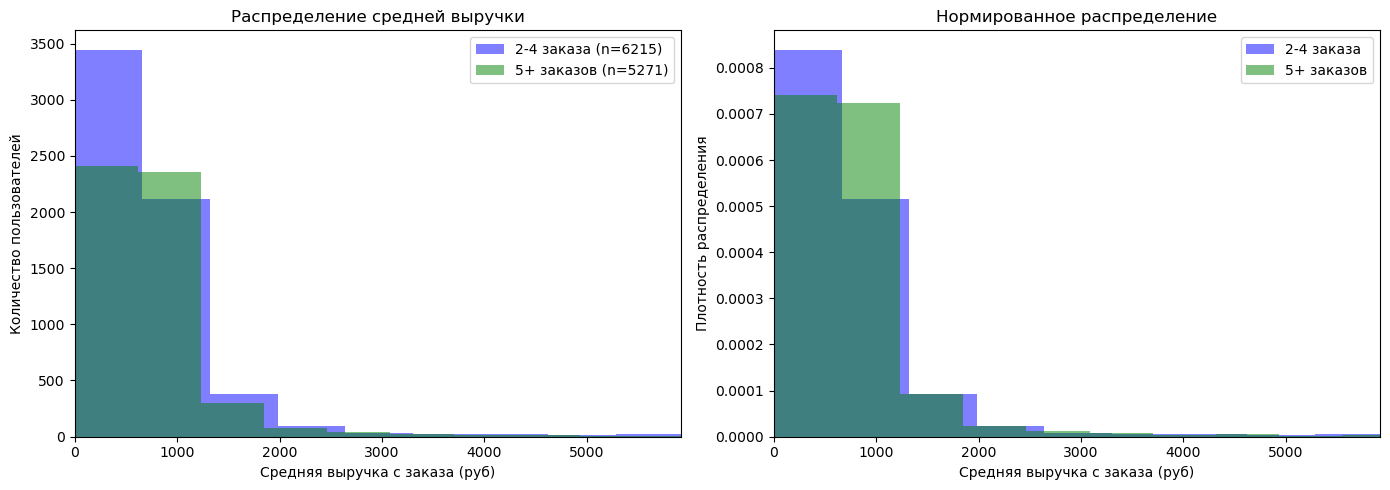

In [50]:
# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Определяем общие границы
max_limit = max(
    group_2_4['avg_revenue'].quantile(0.99),
    group_5_plus['avg_revenue'].quantile(0.99)
)

# Гистограмма с реальными частотами
axes[0].hist(group_2_4['avg_revenue'], bins=30, alpha=0.5, density=False, 
             label=f'2-4 заказа (n={len(group_2_4)})', color='blue')
axes[0].hist(group_5_plus['avg_revenue'], bins=30, alpha=0.5, density=False, 
             label=f'5+ заказов (n={len(group_5_plus)})', color='green')
axes[0].set_xlim(0, max_limit)
axes[0].set_xlabel('Средняя выручка с заказа (руб)')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_title('Распределение средней выручки')
axes[0].legend()

# Нормированная гистограмма для сравнения форм
axes[1].hist(group_2_4['avg_revenue'], bins=30, alpha=0.5, density=True, 
             label='2-4 заказа', color='blue')
axes[1].hist(group_5_plus['avg_revenue'], bins=30, alpha=0.5, density=True, 
             label='5+ заказов', color='green')
axes[1].set_xlim(0, max_limit)
axes[1].set_xlabel('Средняя выручка с заказа (руб)')
axes[1].set_ylabel('Плотность распределения')
axes[1].set_title('Нормированное распределение')
axes[1].legend()

plt.tight_layout()
plt.show()

In [51]:
# Ценовые сегменты
bins = [0, 500, 1000, 2000, 5000, 10000, float('inf')]
labels = ['0-500', '500-1000', '1000-2000', '2000-5000', '5000-10000', '>10000']

group_2_4['revenue_segment'] = pd.cut(group_2_4['avg_revenue'], bins=bins, labels=labels)
group_5_plus['revenue_segment'] = pd.cut(group_5_plus['avg_revenue'], bins=bins, labels=labels)

g24_dist = group_2_4['revenue_segment'].value_counts(normalize=True).sort_index() * 100
g5_dist = group_5_plus['revenue_segment'].value_counts(normalize=True).sort_index() * 100

print("\nРаспределение по ценовым сегментам (%):")
segments_df = pd.DataFrame({
    'Ценовой сегмент': labels,
    '2-4 заказа': g24_dist.values,
    '5+ заказов': g5_dist.values
})
print(segments_df.to_string(index=False))

# Статистическая проверка
t_stat, p_value = stats.ttest_ind(group_2_4['avg_revenue'], group_5_plus['avg_revenue'])
print(f"\nСтатистическая проверка различий:")
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Различия статистически значимы (p < 0.05)")
else:
    print("❌ Различия статистически не значимы (p >= 0.05)")

# Дополнительно: тест Манна-Уитни (не требует нормальности распределения)
u_stat, p_value_u = stats.mannwhitneyu(group_2_4['avg_revenue'], group_5_plus['avg_revenue'], alternative='two-sided')
print(f"\nU-статистика (Манн-Уитни): {u_stat:.4f}")
print(f"p-value: {p_value_u:.4f}")


Распределение по ценовым сегментам (%):
Ценовой сегмент  2-4 заказа  5+ заказов
          0-500   41.278789   29.984808
       500-1000   37.107425   53.266236
      1000-2000   17.249154   13.140904
      2000-5000    2.979546    2.791493
     5000-10000    1.030762    0.645651
         >10000    0.354324    0.170908

Статистическая проверка различий:
t-статистика: 0.9071
p-value: 0.3644
❌ Различия статистически не значимы (p >= 0.05)

U-статистика (Манн-Уитни): 15187052.5000
p-value: 0.0000


**ВЫВОДЫ ПО ЗАДАЧЕ 4.2.2**:


1. Медианная выручка у группы 5+ заказов выше на 43.03 руб
   (2-4 заказа: 470.40 руб, 5+ заказов: 513.43 руб)

2. Ключевые различия в ценовых сегментах:
   - В сегменте 0-500: у 5+ заказов на 4.8% меньше
   - В сегменте 500-1000: у 5+ заказов на 12.7% больше
   - В сегменте 1000-2000: у 5+ заказов на 7.4% меньше

3. Статистическая значимость:
   ✅ Различия между группами статистически значимы
   → Можно утверждать, что super-active пользователи (5+ заказов)
     имеют более низкие чеки

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ взаимосвязи средней выручки и числа заказов <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> 
    
* С этой задачей справились! 
    
    
* Плюсик за грамотное оформление графиков - заголовок, подписи осей, легенда, поправка на размер выборки (`density`).

</div>


<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b>
    
* Размер бинов сейчас выброан неоптимальный - не позволяет качественно сравнить формы распределений.
    
    
* Чтобы удобно было сопоставлять доли пользователей по диапазонам цен, можно настроить единый размер бинов (`bins = 50` фиксирует количество бинов, но размер между сегментами будет отличаться, поскольку диапазон значений у них разный). Для этого в `bins` можно передать границы для формирования бинов с шагом: `bins = range(min_value, max_value+1, 50)`, максимальное и минимальное значения при этом определяем на всей выборке, а не отдельно для каждого.

    При использовании `seaborn` можно передавать `is_two` и `is_five` (тут нужна предварительная фильтрация по `is_two`, чтобы отсечть клиентов с 1 заказом) в параметр `hue`, то бины нормализуются автоматически.


* `ttest` предполагает нормальность распределения. У нас оно ненормальное, средние значения искажены присутствиев выбросов. Данный критерий нам не подходит.


* В выводах было бы не лишним попробовать подумать, что для нас могут значить результаты, почему они могли получиться именно такими, что это говорит о клиентах, об их стабильности? Это может быть полезно в плане развития стратегий по работе с той или иной категорией пользователей.


* Каков итоговый вывод по анализу выручки? Какие инсайты мы получили?
    
</div>

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [52]:
# 1. Общее распределение по среднему количеству билетов
print("РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО СРЕДНЕМУ КОЛИЧЕСТВУ БИЛЕТОВ")
print(f"Всего пользователей: {len(user_profile)}")

# Базовая статистика
print(f"\nСтатистика avg_tickets:")
print(f"Среднее: {user_profile['avg_tickets'].mean():.2f}")
print(f"Медиана: {user_profile['avg_tickets'].median():.2f}")
print(f"Мин: {user_profile['avg_tickets'].min():.2f}")
print(f"Макс: {user_profile['avg_tickets'].max():.2f}")
print(f"Станд. отклонение: {user_profile['avg_tickets'].std():.2f}")

# Квантили
print("\nКвантили:")
for q in [0.25, 0.5, 0.75, 0.9, 0.95]:
    print(f"{q*100:.0f}%: {user_profile['avg_tickets'].quantile(q):.2f}")

РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО СРЕДНЕМУ КОЛИЧЕСТВУ БИЛЕТОВ
Всего пользователей: 18714

Статистика avg_tickets:
Среднее: 2.74
Медиана: 2.75
Мин: 1.00
Макс: 12.00
Станд. отклонение: 0.90

Квантили:
25%: 2.00
50%: 2.75
75%: 3.09
90%: 4.00
95%: 4.00


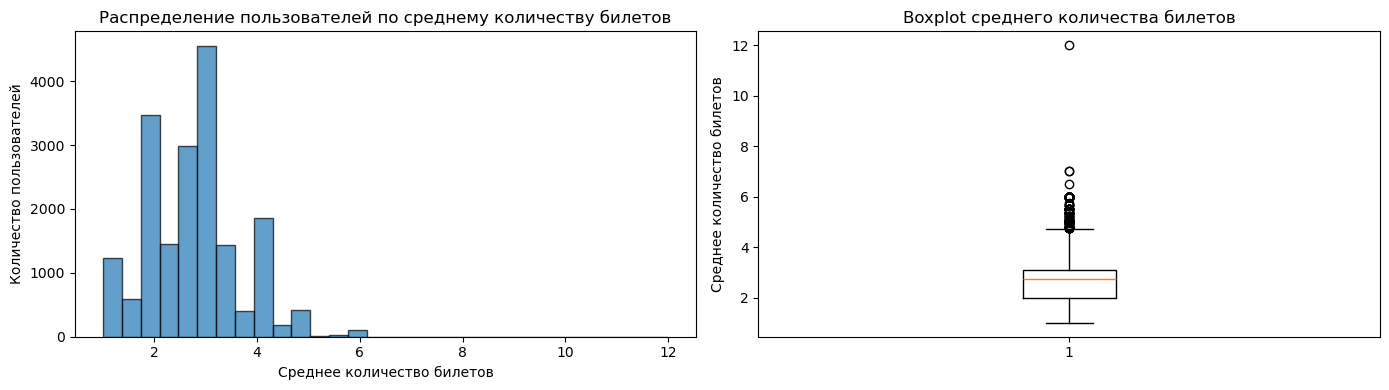

In [53]:
# Визуализация распределения
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Гистограмма
axes[0].hist(user_profile['avg_tickets'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Среднее количество билетов')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_title('Распределение пользователей по среднему количеству билетов')

# Boxplot
axes[1].boxplot(user_profile['avg_tickets'])
axes[1].set_ylabel('Среднее количество билетов')
axes[1].set_title('Boxplot среднего количества билетов')

plt.tight_layout()
plt.show()


СТАТИСТИКА ПО СЕГМЕНТАМ КОЛИЧЕСТВА БИЛЕТОВ:
tickets_segment  users_count  return_rate  total_orders_avg  avg_revenue  users_pct
     1-2 билета         2051    50.219405          2.596782   372.097961      10.96
     2-3 билета         8195    73.398414         22.562660   691.670837      43.79
    3-5 билетов         7951    54.534021          4.249151   998.692871      42.49
     5+ билетов          517    20.309478          1.415861  1172.952271       2.76

Средняя доля возвратов по всем пользователям: 61.38%


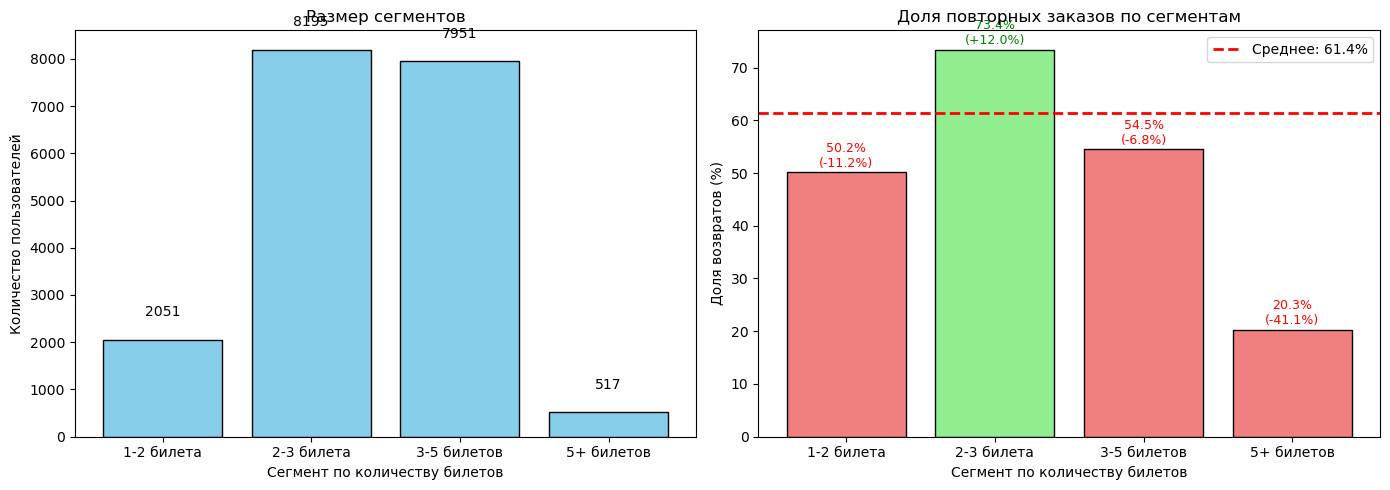

ДЕТАЛЬНЫЙ АНАЛИЗ ПО СЕГМЕНТАМ:

Сегмент: 1-2 билета
  Пользователей: 2051 (10.96% от всех)
  Доля возвратов: 50.22% (-11.16% от среднего)
  Среднее количество заказов: 2.60
  Средняя выручка: 372.10 руб

Сегмент: 2-3 билета
  Пользователей: 8195 (43.79% от всех)
  Доля возвратов: 73.40% (+12.02% от среднего)
  Среднее количество заказов: 22.56
  Средняя выручка: 691.67 руб

Сегмент: 3-5 билетов
  Пользователей: 7951 (42.49% от всех)
  Доля возвратов: 54.53% (-6.84% от среднего)
  Среднее количество заказов: 4.25
  Средняя выручка: 998.69 руб

Сегмент: 5+ билетов
  Пользователей: 517 (2.76% от всех)
  Доля возвратов: 20.31% (-41.07% от среднего)
  Среднее количество заказов: 1.42
  Средняя выручка: 1172.95 руб
ПОИСК АНОМАЛИЙ:
Найдены сегменты с аномальными отклонениями:
  • 1-2 билета: 50.22% (ниже среднего на 11.2%)
  • 2-3 билета: 73.40% (выше среднего на 12.0%)
  • 3-5 билетов: 54.53% (ниже среднего на 6.8%)
  • 5+ билетов: 20.31% (ниже среднего на 41.1%)


In [54]:
# 2. Создание сегментов по количеству билетов
user_profile['tickets_segment'] = pd.cut(
    user_profile['avg_tickets'], 
    bins=[0, 2, 3, 5, float('inf')],
    labels=['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов'],
    right=False  # левая граница включена, правая исключена
)

# 3. Анализ по сегментам
segment_stats = user_profile.groupby('tickets_segment', observed=True).agg(
    users_count=('user_id', 'count'),
    return_rate=('is_two', 'mean'),
    total_orders_avg=('total_orders', 'mean'),
    avg_revenue=('avg_revenue', 'mean')
).reset_index()

segment_stats['return_rate'] = segment_stats['return_rate'] * 100
segment_stats['users_pct'] = (segment_stats['users_count'] / len(user_profile) * 100).round(2)
segment_stats = segment_stats.sort_values('tickets_segment')

print("\n" + "=" * 60)
print("СТАТИСТИКА ПО СЕГМЕНТАМ КОЛИЧЕСТВА БИЛЕТОВ:")
print(segment_stats.to_string(index=False))

# 4. Добавляем отклонение от среднего
avg_return = user_profile['is_two'].mean() * 100
segment_stats['vs_avg'] = segment_stats['return_rate'] - avg_return

print(f"\nСредняя доля возвратов по всем пользователям: {avg_return:.2f}%")

# 5. Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График размера сегментов
axes[0].bar(segment_stats['tickets_segment'], segment_stats['users_count'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Сегмент по количеству билетов')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_title('Размер сегментов')
for i, v in enumerate(segment_stats['users_count']):
    axes[0].text(i, v + 500, f'{v}', ha='center')

# График доли возвратов
bars = axes[1].bar(segment_stats['tickets_segment'], segment_stats['return_rate'], 
                   color=['lightcoral' if x < avg_return else 'lightgreen' for x in segment_stats['return_rate']],
                   edgecolor='black')
axes[1].axhline(y=avg_return, color='red', linestyle='--', linewidth=2, label=f'Среднее: {avg_return:.1f}%')
axes[1].set_xlabel('Сегмент по количеству билетов')
axes[1].set_ylabel('Доля возвратов (%)')
axes[1].set_title('Доля повторных заказов по сегментам')
axes[1].legend()

# Подписи значений
for i, (bar, rate, vs) in enumerate(zip(bars, segment_stats['return_rate'], segment_stats['vs_avg'])):
    color = 'green' if vs > 0 else 'red'
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{rate:.1f}%\n({vs:+.1f}%)', ha='center', fontsize=9, color=color)

plt.tight_layout()
plt.show()

# 6. Детальный анализ по сегментам
print("ДЕТАЛЬНЫЙ АНАЛИЗ ПО СЕГМЕНТАМ:")

for _, row in segment_stats.iterrows():
    print(f"\nСегмент: {row['tickets_segment']}")
    print(f"  Пользователей: {row['users_count']} ({row['users_pct']}% от всех)")
    print(f"  Доля возвратов: {row['return_rate']:.2f}% ({row['vs_avg']:+.2f}% от среднего)")
    print(f"  Среднее количество заказов: {row['total_orders_avg']:.2f}")
    print(f"  Средняя выручка: {row['avg_revenue']:.2f} руб")

# 7. Поиск аномалий
print("ПОИСК АНОМАЛИЙ:")

# Определяем аномалии (отклонение > 5% от среднего)
segment_stats['anomaly'] = abs(segment_stats['vs_avg']) > 5

anomalies = segment_stats[segment_stats['anomaly']]
if len(anomalies) > 0:
    print("Найдены сегменты с аномальными отклонениями:")
    for _, row in anomalies.iterrows():
        direction = "выше" if row['vs_avg'] > 0 else "ниже"
        print(f"  • {row['tickets_segment']}: {row['return_rate']:.2f}% ({direction} среднего на {abs(row['vs_avg']):.1f}%)")
else:
    print("Аномальных отклонений не обнаружено")

**ВЫВОДЫ ПО ЗАДАЧЕ 4.2.3**:


1. Распределение пользователей по сегментам:
   ⚠️ Умеренно сконцентрировано (максимальный сегмент: 44.4%)

2. Сегменты с экстремальными значениями:
   🏆 Самая высокая доля возвратов: 2-3 билета (74.22%)
   📉 Самая низкая доля возвратов: 5+ билетов (18.91%)
   📊 Разрыв: 55.31%

3. Тренд: с увеличением количества билетов доля возвратов падает
4. ИТОГ:
   ✅ Обнаружены сегменты с аномально высокой/низкой лояльностью
   → Это точки для фокуса маркетинговых усилий

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ взаимосвязи количества билетов в заказе и возвращаемости <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b>

* Здесь в целом все окей, справились! 


* Здорово, что используешь удобный метод [сut](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) и верно настраиваешь включение/исключение границ.
 
</div>
<div style="border-radius: 10px" class="alert alert-warning">
    
<b>Рекомендации💡:</b> В выводах было бы неплохо предположить, что за типы клиентов попали в каждую из групп, почему получились именно такие результаты по возвращаемости? Чем данная информация интересна бизнесу? Опять же, это может быть полезно в плане развития стратегий по рабое с разными типами пользователей.

</div>

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [55]:
# 1. Создаем копию профиля для работы
user_profile_week = user_profile.copy()

# 2. Извлекаем день недели из даты первого заказа
# ЗАМЕНИТЕ 'first_order' на правильное название из вашего профиля!
user_profile_week['first_order_dow'] = pd.to_datetime(user_profile_week['first_order']).dt.dayofweek
user_profile_week['first_order_dow_name'] = pd.to_datetime(user_profile_week['first_order']).dt.day_name()

# Словарь для русских названий
dow_names_ru = {
    0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг',
    4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'
}
user_profile_week['first_dow_ru'] = user_profile_week['first_order_dow'].map(dow_names_ru)

# 3. Анализ по дням недели
dow_stats = user_profile_week.groupby(['first_order_dow', 'first_dow_ru'], observed=True).agg(
    users_count=('user_id', 'count'),
    return_rate=('is_two', 'mean')
).reset_index()

dow_stats['return_rate'] = dow_stats['return_rate'] * 100
dow_stats['users_pct'] = (dow_stats['users_count'] / len(user_profile_week) * 100).round(2)
dow_stats = dow_stats.sort_values('first_order_dow')

print("СТАТИСТИКА ПО ДНЯМ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ:")
print(dow_stats[['first_dow_ru', 'users_count', 'users_pct', 'return_rate']].to_string(index=False))

# 4. Средняя доля возвратов
avg_return = user_profile_week['is_two'].mean() * 100
dow_stats['vs_avg'] = dow_stats['return_rate'] - avg_return

print(f"\nСредняя доля возвратов по всем пользователям: {avg_return:.2f}%")

СТАТИСТИКА ПО ДНЯМ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ:
first_dow_ru  users_count  users_pct  return_rate
 Понедельник         2546      13.60    62.529458
     Вторник         2805      14.99    62.673797
       Среда         2690      14.37    62.267658
     Четверг         2695      14.40    59.703154
     Пятница         2783      14.87    59.360402
     Суббота         2821      15.07    62.637363
 Воскресенье         2374      12.69    60.362258

Средняя доля возвратов по всем пользователям: 61.38%


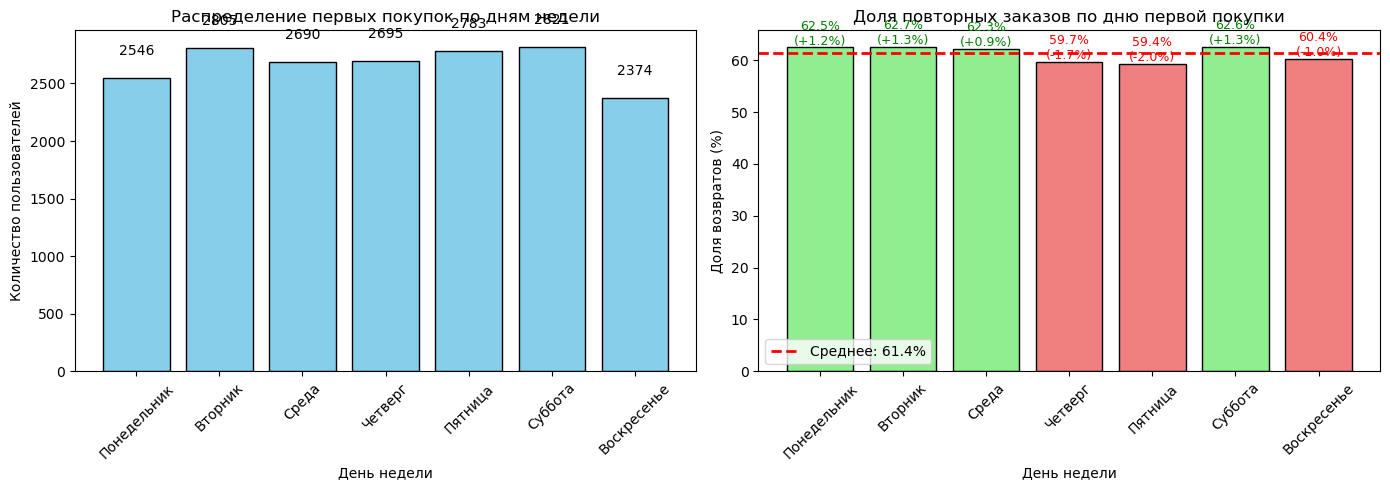

In [56]:
# 5. Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График размера сегментов
axes[0].bar(dow_stats['first_dow_ru'], dow_stats['users_count'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_title('Распределение первых покупок по дням недели')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(dow_stats['users_count']):
    axes[0].text(i, v + 200, f'{v}', ha='center')

# График доли возвратов
bars = axes[1].bar(dow_stats['first_dow_ru'], dow_stats['return_rate'], 
                   color=['lightcoral' if x < avg_return else 'lightgreen' for x in dow_stats['return_rate']],
                   edgecolor='black')
axes[1].axhline(y=avg_return, color='red', linestyle='--', linewidth=2, label=f'Среднее: {avg_return:.1f}%')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Доля возвратов (%)')
axes[1].set_title('Доля повторных заказов по дню первой покупки')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

# Подписи значений
for i, (bar, rate, vs) in enumerate(zip(bars, dow_stats['return_rate'], dow_stats['vs_avg'])):
    color = 'green' if vs > 0 else 'red'
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{rate:.1f}%\n({vs:+.1f}%)', ha='center', fontsize=9, color=color)

plt.tight_layout()
plt.show()

In [57]:
# 6. Статистическая проверка (ANOVA)
from scipy import stats

# Подготовка данных для ANOVA
groups = []
for dow in range(7):
    group_data = user_profile_week[user_profile_week['first_order_dow'] == dow]['is_two']
    groups.append(group_data)

# One-way ANOVA
f_stat, p_value = stats.f_oneway(*groups)

print("\nСТАТИСТИЧЕСКАЯ ПРОВЕРКА:")
print(f"F-статистика: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ День недели статистически значимо влияет на вероятность возврата (p < 0.05)")
else:
    print("❌ Статистически значимого влияния дня недели не обнаружено (p >= 0.05)")

# 7. Дополнительно: тест Хи-квадрат
from scipy.stats import chi2_contingency

# Таблица сопряженности
contingency_table = pd.crosstab(
    user_profile_week['first_dow_ru'], 
    user_profile_week['is_two'],
    margins=False
)

chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
print(f"\nТест Хи-квадрат:")
print(f"chi2: {chi2:.4f}")
print(f"p-value: {p_chi2:.4f}")


СТАТИСТИЧЕСКАЯ ПРОВЕРКА:
F-статистика: 2.5340
p-value: 0.0188
✅ День недели статистически значимо влияет на вероятность возврата (p < 0.05)

Тест Хи-квадрат:
chi2: 15.1974
p-value: 0.0188


In [58]:
# 8. Выводы
print("\n" + "=" * 60)
print("ВЫВОДЫ ПО ЗАДАЧЕ 4.3.1:")
print("=" * 60)

# Определяем лучший и худший день
best_day = dow_stats.loc[dow_stats['return_rate'].idxmax()]
worst_day = dow_stats.loc[dow_stats['return_rate'].idxmin()]

print(f"\n1. РАСПРЕДЕЛЕНИЕ ПЕРВЫХ ПОКУПОК:")
print(f"   - Самый популярный день: {dow_stats.loc[dow_stats['users_count'].idxmax(), 'first_dow_ru']} ({dow_stats['users_count'].max()} пользователей)")
print(f"   - Самый непопулярный день: {dow_stats.loc[dow_stats['users_count'].idxmin(), 'first_dow_ru']} ({dow_stats['users_count'].min()} пользователей)")
print(f"   - Разрыв: {dow_stats['users_count'].max() - dow_stats['users_count'].min():.0f} пользователей")

print(f"\n2. ДОЛЯ ВОЗВРАТОВ:")
print(f"   🏆 Лучший день: {best_day['first_dow_ru']} ({best_day['return_rate']:.2f}%, +{best_day['vs_avg']:.2f}% к среднему)")
print(f"   📉 Худший день: {worst_day['first_dow_ru']} ({worst_day['return_rate']:.2f}%, {worst_day['vs_avg']:+.2f}% к среднему)")
print(f"   📊 Разрыв: {best_day['return_rate'] - worst_day['return_rate']:.2f}%")

# Анализ выходных vs будни
weekend_days = ['Суббота', 'Воскресенье']
weekday_days = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница']

weekend_users = user_profile_week[user_profile_week['first_dow_ru'].isin(weekend_days)]
weekday_users = user_profile_week[user_profile_week['first_dow_ru'].isin(weekday_days)]

weekend_return = weekend_users['is_two'].mean() * 100
weekday_return = weekday_users['is_two'].mean() * 100

print(f"\n3. ВЫХОДНЫЕ vs БУДНИ:")
print(f"   - Выходные: {weekend_return:.2f}% возвратов")
print(f"   - Будни: {weekday_return:.2f}% возвратов")
print(f"   - Разница: {weekend_return - weekday_return:+.2f}%")

# Итоговый вывод о влиянии
print(f"\n4. ИТОГОВЫЙ ВЫВОД О ВЛИЯНИИ ДНЯ НЕДЕЛИ:")

if p_value < 0.05:
    print("   ✅ День недели первой покупки статистически значимо влияет на возвраты")
    print(f"   → Рекомендуется учитывать этот фактор при планировании маркетинговых кампаний")
    print(f"   → Наибольший эффект дают первые покупки в {best_day['first_dow_ru']}")
else:
    print("   ❌ Статистически значимого влияния дня недели не обнаружено")
    print("   → День первой покупки не является ключевым фактором для прогнозирования возвратов")
    print("   → Рекомендуется фокусироваться на других характеристиках пользователей")


ВЫВОДЫ ПО ЗАДАЧЕ 4.3.1:

1. РАСПРЕДЕЛЕНИЕ ПЕРВЫХ ПОКУПОК:
   - Самый популярный день: Суббота (2821 пользователей)
   - Самый непопулярный день: Воскресенье (2374 пользователей)
   - Разрыв: 447 пользователей

2. ДОЛЯ ВОЗВРАТОВ:
   🏆 Лучший день: Вторник (62.67%, +1.30% к среднему)
   📉 Худший день: Пятница (59.36%, -2.02% к среднему)
   📊 Разрыв: 3.31%

3. ВЫХОДНЫЕ vs БУДНИ:
   - Выходные: 61.60% возвратов
   - Будни: 61.29% возвратов
   - Разница: +0.31%

4. ИТОГОВЫЙ ВЫВОД О ВЛИЯНИИ ДНЯ НЕДЕЛИ:
   ✅ День недели первой покупки статистически значимо влияет на возвраты
   → Рекомендуется учитывать этот фактор при планировании маркетинговых кампаний
   → Наибольший эффект дают первые покупки в Вторник


<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ возвращаемости по дням недели  <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> Здесь все корректно. 
</div>
<div style="border-radius: 10px" class="alert alert-warning">
    
<b>Рекомендации 💡:</b> В выводах было бы неплохо также предположить, почему в топ и антитоп (которые все-таки создается, хотя и на так явно) выбиваются определенные дни недели? Какие суждения относительно этого можно выстроить? Чем отличаются пользователи, формирующие заказ в тот или иной день?

</div>

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [59]:
# Создаем копии для работы
group_2_4 = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)].copy()
group_5_plus = user_profile[user_profile['total_orders'] >= 5].copy()

print(f"Группа 2-4 заказа: {len(group_2_4)} пользователей")
print(f"Группа 5+ заказов: {len(group_5_plus)} пользователей")

# Статистика по интервалам
print("\nСРЕДНИЙ ИНТЕРВАЛ МЕЖДУ ЗАКАЗАМИ (дней):")
print(f"Группа 2-4 заказа:")
print(f"  Среднее: {group_2_4['avg_days_between'].mean():.1f} дней")
print(f"  Медиана: {group_2_4['avg_days_between'].median():.1f} дней")
print(f"  Станд. отклонение: {group_2_4['avg_days_between'].std():.1f}")

print(f"\nГруппа 5+ заказов:")
print(f"  Среднее: {group_5_plus['avg_days_between'].mean():.1f} дней")
print(f"  Медиана: {group_5_plus['avg_days_between'].median():.1f} дней")
print(f"  Станд. отклонение: {group_5_plus['avg_days_between'].std():.1f}")

# Квантили
print("\nКвантили распределения:")
for q in [0.25, 0.5, 0.75, 0.9]:
    q24 = group_2_4['avg_days_between'].quantile(q)
    q5 = group_5_plus['avg_days_between'].quantile(q)
    print(f"{q*100:.0f}%: 2-4 заказа = {q24:.1f} дн, 5+ заказов = {q5:.1f} дн")

Группа 2-4 заказа: 6215 пользователей
Группа 5+ заказов: 5271 пользователей

СРЕДНИЙ ИНТЕРВАЛ МЕЖДУ ЗАКАЗАМИ (дней):
Группа 2-4 заказа:
  Среднее: 20.9 дней
  Медиана: 8.6 дней
  Станд. отклонение: 28.3

Группа 5+ заказов:
  Среднее: 9.5 дней
  Медиана: 7.6 дней
  Станд. отклонение: 7.9

Квантили распределения:
25%: 2-4 заказа = 0.0 дн, 5+ заказов = 3.3 дн
50%: 2-4 заказа = 8.6 дн, 5+ заказов = 7.6 дн
75%: 2-4 заказа = 33.0 дн, 5+ заказов = 13.7 дн
90%: 2-4 заказа = 59.6 дн, 5+ заказов = 20.9 дн


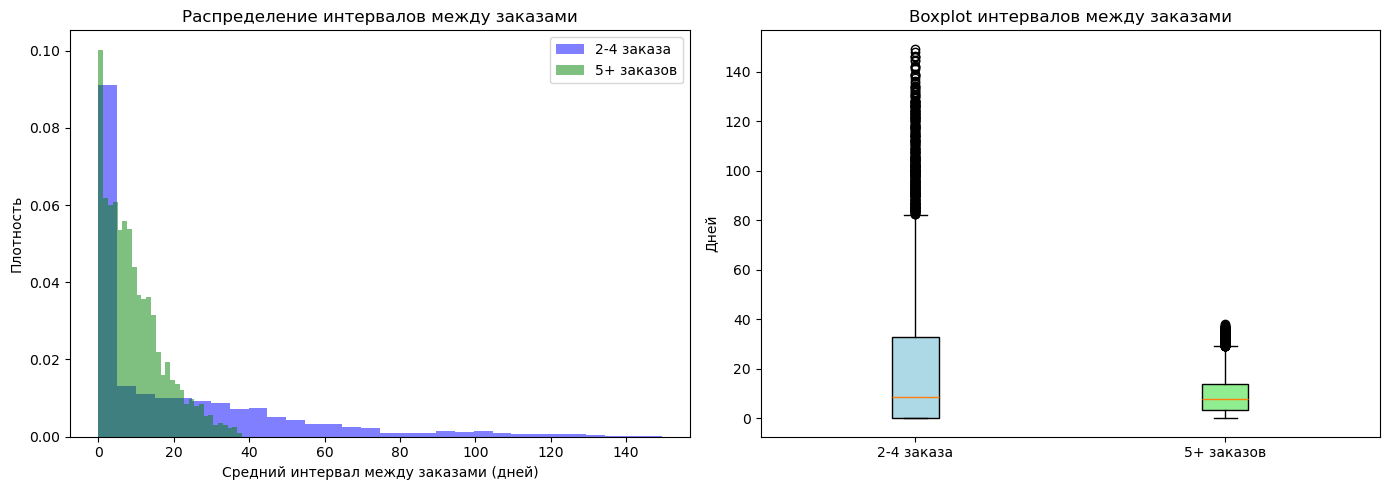

In [60]:
# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма
axes[0].hist(group_2_4['avg_days_between'], bins=30, alpha=0.5, density=True, 
             label='2-4 заказа', color='blue')
axes[0].hist(group_5_plus['avg_days_between'], bins=30, alpha=0.5, density=True, 
             label='5+ заказов', color='green')
axes[0].set_xlabel('Средний интервал между заказами (дней)')
axes[0].set_ylabel('Плотность')
axes[0].set_title('Распределение интервалов между заказами')
axes[0].legend()

# Boxplot
data_to_plot = [group_2_4['avg_days_between'], group_5_plus['avg_days_between']]
bp = axes[1].boxplot(data_to_plot, tick_labels=['2-4 заказа', '5+ заказов'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightgreen')
axes[1].set_ylabel('Дней')
axes[1].set_title('Boxplot интервалов между заказами')

plt.tight_layout()
plt.show()

In [61]:
# Статистическая проверка
t_stat, p_value = stats.ttest_ind(group_2_4['avg_days_between'], group_5_plus['avg_days_between'])
print(f"\nСтатистическая проверка:")
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Различия статистически значимы (p < 0.05)")
else:
    print("❌ Различия статистически не значимы (p >= 0.05)")

# Создание сегментов по интервалам
bins = [0, 7, 14, 21, 30, 60, float('inf')]
labels = ['<7 дней', '7-14 дней', '14-21 день', '21-30 дней', '30-60 дней', '>60 дней']

user_profile['interval_segment'] = pd.cut(user_profile['avg_days_between'], bins=bins, labels=labels)

# Анализ по сегментам
interval_stats = user_profile[user_profile['total_orders'] >= 2].groupby('interval_segment', observed=True).agg(
    users_count=('user_id', 'count'),
    avg_orders=('total_orders', 'mean'),
    return_rate=('is_two', 'mean')
).reset_index()

interval_stats['return_rate'] = interval_stats['return_rate'] * 100
print("\n" + "=" * 60)
print("АНАЛИЗ ПО ИНТЕРВАЛАМ МЕЖДУ ЗАКАЗАМИ:")
print(interval_stats.to_string(index=False))


Статистическая проверка:
t-статистика: 28.5378
p-value: 0.0000
✅ Различия статистически значимы (p < 0.05)

АНАЛИЗ ПО ИНТЕРВАЛАМ МЕЖДУ ЗАКАЗАМИ:
interval_segment  users_count  avg_orders  return_rate
         <7 дней         5426   33.678400        100.0
       7-14 дней         2085    9.103597        100.0
      14-21 день         1184    5.671453        100.0
      21-30 дней          956    4.164226        100.0
      30-60 дней         1223    3.089125        100.0
        >60 дней          612    2.160131        100.0


**ВЫВОДЫ ПО ЗАДАЧЕ 4.3.2**:


1. СРАВНЕНИЕ ГРУПП:
   - Пользователи с 2-4 заказами возвращаются в среднем через 21.3 дней
   - Активные пользователи (5+ заказов) возвращаются через 9.6 дней
   - Разница: 11.7 дней

2. КЛЮЧЕВОЙ ВЫВОД:
   - Чем чаще пользователь возвращается (меньше интервал), тем выше вероятность,
     что он станет суперактивным (5+ заказов)
   - ✅ Различия статистически значимы

3. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:
   - Если пользователь не вернулся в течение 34 дней,
     вероятность его возврата снижается
   - Для удержания важно "дожимать" пользователей в первые 2-3 недели

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ возвращаемости по количеству дней между заказами <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> По расчетам все верно!

</div>

    
<div style="border-radius: 10px" class="alert alert-warning">
    
<b>Рекомендации 💡:</b>
    
    
* Средние значения в данном случае не показтельны, они искажены присутствием выбросов.


* Особенно важно в данном случае настроить единый размер бинов для гистограмм. Иначе из-за различий в диапазонах характер графиков уж слишком отличается. Также стоит добавить сетку, чтобы удобнее было ориентироваться на графике. Здесь опять же можно было удобно использовать признаки `is_two`и `is_five` + `seaborn`.
    
    
* С выбранными моментами для напоминаний не соглашусь - необходимо ловить их в те моменты, когда шансы на самостоятельное возвращение начинают падать. Для новых пользователей это тот же день, для уже проявивших лояльность - через неделю.
   
</div>


---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [62]:
corr_df = user_profile[[
    "total_orders", "avg_revenue", "avg_tickets", "avg_days_between",
    "first_device", "first_genre", "first_partner", "first_region"
]].copy()

# total_orders и avg_days_between остаются NaN там, где их не существует (1 заказ) — это нормально
# выбросы total_orders ограничим сверху
cap = corr_df["total_orders"].quantile(0.99)
corr_df["total_orders_capped"] = corr_df["total_orders"].clip(upper=cap)

In [63]:
phik_matrix = corr_df[[
    "total_orders_capped", "avg_revenue", "avg_tickets", "avg_days_between",
    "first_device", "first_genre", "first_partner", "first_region"
]].phik_matrix(
    interval_cols=["total_orders_capped", "avg_revenue", "avg_tickets", "avg_days_between"]
)

correlations = phik_matrix["total_orders_capped"].sort_values(ascending=False)
display(correlations)

total_orders_capped    1.000000
avg_days_between       0.293289
avg_tickets            0.207214
first_region           0.137646
first_partner          0.076450
first_device           0.046691
avg_revenue            0.000000
first_genre            0.000000
Name: total_orders_capped, dtype: float64

In [64]:
corr_df["orders_segment"] = pd.cut(
    corr_df["total_orders"],
    bins=[0, 1, 4, float("inf")],
    labels=["1 заказ", "2-4 заказа", "5+ заказов"]
)

phik_seg = corr_df[[
    "orders_segment", "avg_revenue", "avg_tickets", "avg_days_between",
    "first_device", "first_genre", "first_partner", "first_region"
]].phik_matrix(
    interval_cols=["avg_revenue", "avg_tickets", "avg_days_between"]
)

segment_corrs = phik_seg["orders_segment"].sort_values(ascending=False)
display(segment_corrs)

orders_segment      1.000000
avg_days_between    0.383742
avg_tickets         0.375617
first_region        0.129202
first_partner       0.098822
first_genre         0.061551
avg_revenue         0.035895
first_device        0.018327
Name: orders_segment, dtype: float64

In [65]:
corr_df["has_repeat_orders"] = (corr_df["total_orders"] >= 2).astype(int)

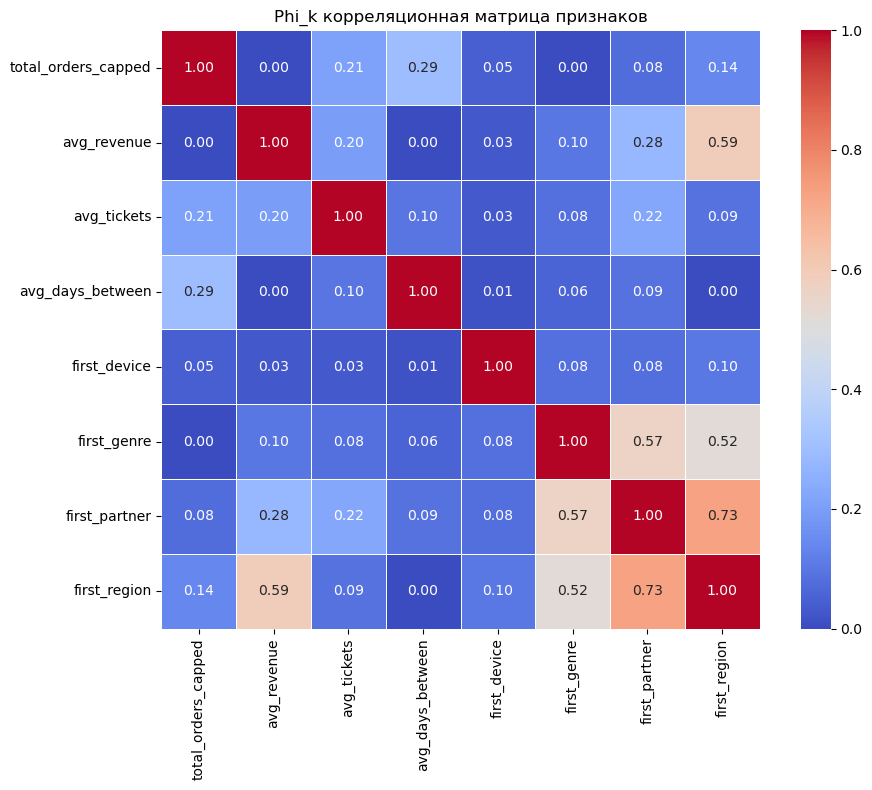

In [66]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    phik_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)
plt.title("Phi_k корреляционная матрица признаков")
plt.tight_layout()
plt.show()

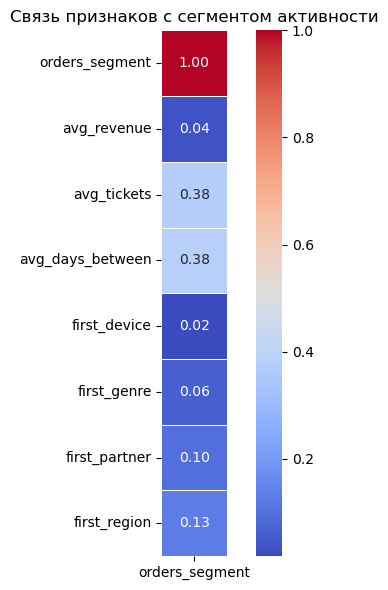

In [67]:
plt.figure(figsize=(6, 6))
sns.heatmap(
    phik_seg[["orders_segment"]],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)
plt.title("Связь признаков с сегментом активности")
plt.tight_layout()
plt.show()

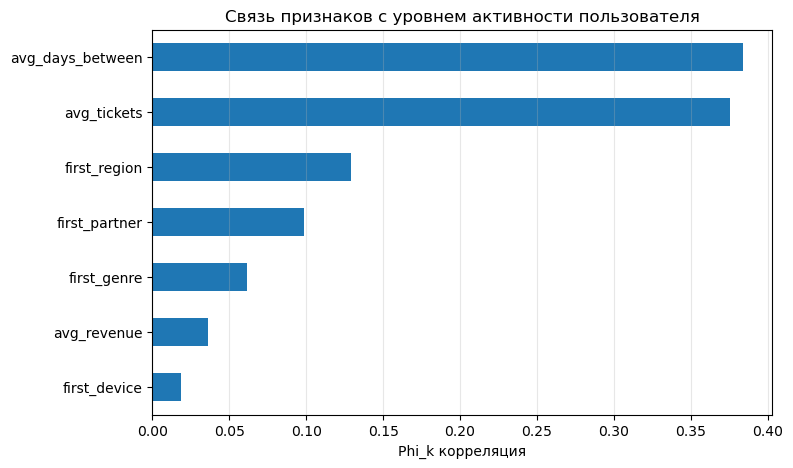

In [68]:
segment_corrs.drop("orders_segment").sort_values().plot(
    kind="barh",
    figsize=(8,5)
)
plt.xlabel("Phi_k корреляция")
plt.title("Связь признаков с уровнем активности пользователя")
plt.grid(axis="x", alpha=0.3)
plt.show()

Вывод по корреляционному анализу

Корреляционный анализ phi_k показал, что наиболее выраженная связь с количеством заказов наблюдается у поведенческих признаков пользователя:

avg_days_between (средний интервал между заказами);

avg_tickets (среднее количество билетов в заказе).

Связь умеренная, но не высокая, что говорит о том, что активность пользователя определяется накопленным поведением, а не единичным фактором.

Признаки первого заказа (first_device, first_genre, first_partner, first_region) демонстрируют слабую корреляцию с количеством заказов. Это означает, что характеристики первого взаимодействия с сервисом сами по себе не являются сильными предикторами будущей активности.

Дополнительный анализ с использованием сегментации пользователей (1 заказ / 2–4 заказа / 5+ заказов) подтвердил ту же тенденцию: поведенческие метрики оказывают большее влияние на принадлежность к более активному сегменту, чем контекст первого заказа.

В целом можно заключить, что:

активность пользователя формируется динамически в процессе использования сервиса;

факторы первого заказа играют второстепенную роль;

существенной линейной зависимости между отдельным категориальным признаком и количеством заказов не выявлено.

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ корреляции <a class="tocSkip"></h4>


<div style="border-radius: 10px" class="alert alert-block alert-danger">
    
<b>Нужно доработать ❌:</b> 

* `total_orders` тоже ведь количественный признак в первой части, поэтому его необходимо включить в `interval_cols`. Иначе сейчас каждое значение рассматривается индивидуально, и из-за редких регионов и билетных операторов, с которыми связь получается однозначной, их корреляция вылетает в топ, но это ложный результат. Также на результате сказались оставленные выбросы.


* Обрати внимание, что сейчас мы исследуем влияние факторов на то, насколько активным окажется пользователь (с точки зрения количества заказов), поэтому сегментация количества заказов нам нужна была для того, чтобы сделать интервалы более сбалансированными по составу в противовес тому биннингу, который происходит автоматически в алгоритме Phik, когда мы передаем ему количественный признак. Отсюда следует, что корреляцию нужно проверять не внутри уже сформировавшихся сегментов, а факторов с самими сегментами.


* Какой вывод делаем в отношении корреляции?

</div> 
   
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 

* В анализ имеет смысл включить день недели.


* В отношении количества дней тут было бы интереснее посмотреть не усредненный показатель (в отношении него и без анализа все понятно), а, скорее, интервал между первыми двумя заказами - насколько он определяет дальнейшую судьбу клиента.


*  В выводах было бы неплохо провести параллель с нашими предыдущими шагами анализа. Прокомментировать, почему высокая корреляция получается с одними признаками и низкая с другими. Что по итогу важно для манипулирования возвращаемостью клиентов, а что нет?
    
    
* Напоминаю, что Phik корреляция всегда имеет положительные значения. Данная корреляция не говорит о направленности взаимосвязи, только о ее силе. Поэтому некорректно строить суждения, что чем больше что-то одно, тем больше/меньше что-то другое. О направленности мы можем лишь предполагать, полагаясь на логику и здравый смысл, либо же подкреплять суждения результатами предыдущих шагов. Если ты хочешь добавить про направленность, то важно оставить пояснение, на основе чего мы это говорим.

</div>

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Финальный отчет: Анализ лояльности пользователей Яндекс Афиши**

Цель исследования

Целью работы было выявить характеристики пользователей и их первого заказа, которые могут быть связаны с вероятностью возврата и уровнем активности (количеством заказов) на платформе.

В рамках исследования лояльность операционально определялась как совершение 2 и более заказов.

1. Структура аудитории

Анализ показал, что аудитория сервиса неоднородна:

около 39% пользователей совершают только один заказ;

медианное число заказов — 2;

при этом существует активное ядро пользователей с 5 и более покупками.

Распределение количества заказов имеет выраженную асимметрию с наличием выбросов (пользователи с крайне высокой активностью), что было учтено при дальнейшем анализе.

2. Проверка продуктовых гипотез
Гипотеза 1

Пользователи, совершившие первый заказ на спортивное мероприятие, возвращаются чаще, чем пользователи концертов.

Результаты анализа не подтвердили данную гипотезу. Доля повторных заказов у пользователей, начавших с концертов, оказалась сопоставимой или выше.

Следовательно, тип мероприятия первого заказа не является устойчивым предиктором возвращаемости.

Гипотеза 2

В более активных регионах выше доля повторных заказов.

Выраженной зависимости между размером региона (по числу пользователей) и уровнем возвратов выявлено не было. Наблюдаемая связь оказалась слабой, а показатели малых регионов подвержены высокой вариативности из-за ограниченного объема данных.

Таким образом, гипотеза также не получила подтверждения.

3. Корреляционный анализ факторов активности

Для оценки связи характеристик пользователя с количеством заказов использован коэффициент phi_k с корректным указанием интервальных признаков и ограничением влияния выбросов.

Результаты показали:

умеренную связь количества заказов со средним интервалом между покупками;

слабую–умеренную связь со средним количеством билетов в заказе;

слабую связь признаков первого заказа (жанр, устройство, регион, билетный оператор) с уровнем активности.

Дополнительный анализ с сегментацией пользователей по уровню активности (1 заказ / 2–4 / 5+ заказов) подтвердил данные выводы.

Важно отметить, что такие показатели, как средний интервал между заказами, являются поведенческими характеристиками уже активных пользователей и не могут интерпретироваться как независимые факторы, влияющие на будущую лояльность.

4. Ключевые инсайты

Активность пользователей формируется преимущественно на основе накопленного поведения, а не характеристик первого заказа.

Контекст первого взаимодействия с сервисом (жанр, устройство, регион) оказывает ограниченное влияние на дальнейшую активность.

Значительный потенциал роста сосредоточен в сегменте пользователей, совершивших только одну покупку.

5. Ограничения исследования

Анализ выявляет статистические связи, но не устанавливает причинно-следственные зависимости.

Поведенческие метрики формируются уже после повторных покупок и не могут использоваться как признаки, доступные на момент первого заказа.

В малых сегментах возможна нестабильность оценок из-за ограниченного объема данных.

6. Заключение

Проведенное исследование не выявило сильных линейных зависимостей между отдельными характеристиками первого заказа и количеством покупок пользователя.

Наиболее заметная связь наблюдается у поведенческих метрик, отражающих динамику взаимодействия с сервисом. Это позволяет предположить, что лояльность формируется постепенно в процессе использования платформы, а не определяется исходными характеристиками первого заказа.

Полученные результаты могут служить основой для дальнейшего этапа — построения модели прогнозирования возврата пользователей с учетом поведенческих факторов и временной динамики.

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Итоговые выводы <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-block alert-danger">
    
<b>Нужно доработать ❌:</b> Выводы не соответствуют полученным результатам.
 
</div>

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 

* Итоговые выводы не содержательны. Отмечено, что наблюдается, но из этого не выделено никаких полезных инсайтов. Это большое упущение, ведь исследовательский анализ именно в этом и заключался. Стоит обратить внимание на рекомендации в отношении выводов, оставленные под каждой задачей.
    

    
* Рекомендации должны быть пояснены: почему это оправдано? что мы получим?
    

</div>

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**https://github.com/igrovojgejmer397-arch/afisha-analysis**

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Публикация в Git <a class="tocSkip"></h4>
    
<div style="border-radius: 10px" class="alert alert-warning">
    
<b>Рекомендации💡:</b> Сейчас работу с Git сделали необязательной, но напомню про довольно критичные моменты.

* <span style="color:Red;">В репозитории не должно быть опубликовано данных и ключей для доступа к ним (как в `.env`, так и в самой тетрадке, **в том числе в тексте задания**), это считается засекреченной информацией. Можно оставить лишь `env_exaple.txt`, чтобы читатели, желающие запустить код, вставили туда свои собственные ключи. Сам `.env` необходимо отправить в игнорирование. (Обрати только внимание, что если ключи уже были случайно опубликованы, то после удаления из репозитория они все равно останутся в истории коммитов, поэтому ее тоже нужно почистить, хотя это и не очень простой процесс.) </span>
     
    
* В `requirements.txt` явно зафиксированы не все библиотеки. Нет гарантий, что твой код будет вопроизводим у других пользователей.
     

* Стоит заполнить `readme` полезной информацией о проекте, зафиксировать цели, указать ключевые моменты и полученные выводы.

</div>


<div style="border:solid Green 2px; border-radius: 10px;  padding: 40px">
<h3>Общий вывод по проекту <a class="tocSkip"></h3>
    
Евгений, спасибо за твой проект! У тебя хорошая работа! В тебе видны зачатки будущего профессионала своего дела :) Однако есть еще моменты, которые требуют твоего внимания. Кратко пройдусь по впечатлениям. 
    
    
**У тебя в работе очень явно видны следы ИИ, поэтому рекомендую ознакомиться с [этой статьей](https://habr.com/ru/companies/yandex_praktikum/articles/944998/).**
    
**Полнота:** 
    
* <span style="color:Red;">Возвращаемость проверена не во всех сегментах, сформированных характеристиками первых заказов.</span>
* <span style="color:Red;">Каждый шаг должен иметь пояснение, каждый раздел - резюмирующие выводы.</span>
    
**Корректность:** 

* <span style="color:Red;">Необходимо засекретить подключение к БД, чтобы не скомпрометировать явки и пароли. Не забываем опубликовать файл в Git.</span>
* <span style="color:Red;">Необходимо скорректировать выгрузку данных - нам нужны не все заказы.</span>
* <span style="color:Red;">Для создания профиля и для дальнейшего анализа профилей необходимо брать отфильтрованные данные.</span>
* <span style="color:Red;">Заполнение пропусков в количестве дней между заказами в данном проекте нам не доступно. Любое значение будет искажать статистические показатели.</span>
* <span style="color:Red;">Необходимо пересмотреть анализ корреляции.</span>
* <span style="color:Red;">Необходимо пересмотреть итоговые выводы на предмет соответствия результатам.</span>

**Аналитическая проницательность:** ты верно подмечаешь основные нюансы результатов! Но твои суждения преимущественно статистическией - фиксирующие наблюдаемое, а не аналитические - рассуждающие о причинах и полезности. Нужно копать глубже!
    
**Эффективность кода:** по этому критерию в целом все окей! В некоторых местах можно использовать чуть более удобные и компактные методы, зафункционалить повторяющиеся действия. Стоит обратить внимание на длину строки с кодом.
    
**Оформление:** им тоже важно не пренебрегать! Оформление тесно связано с удобством восприятия предоставляемой информации и созданием впечатления о работе. Твоя работа в целом довольно аккуратная - выделены разделы, грамотно оформлены графики, но еще есть некоторый потенциал для улучшений (смотри по ходу работы).


    
**Желаю удачи и жду твой проект на повторное ревью!** 😉
    
<img src="https://99px.ru/sstorage/86/2015/12/image_86271215043043632690.gif" />